In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from scipy.stats import spearmanr

from rdkit import Chem
from rdkit.Chem import Draw, Descriptors
from rdkit.ML.Descriptors import MoleculeDescriptors
#from mordred import Calculator, descriptors
import networkx as nx
from featurizer import Featurizer
from tqdm import tqdm

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


#### <b>EDA on the labels</b>

In [ ]:
# taken from EDA notebook from lecture
def canonicalize_smiles(smiles, isomeric:bool=True):
    """
    Convert any SMILES to its canonical form.
    
    Args:
        smiles (str): Input SMILES string
        
    Returns:
        str: Canonical SMILES
    """
    mol = Chem.MolFromSmiles(smiles) 
    if mol is None:
        return None  # Invalid SMILES
    return Chem.MolToSmiles(mol, isomericSmiles=isomeric)

def ml_stats_report(df):
    num_df = df.select_dtypes(include=[np.number])
    report = pd.DataFrame({
        'num_missing': num_df.isna().sum(),
        'percent_missing': num_df.isna().mean() * 100,
        'mean': num_df.mean(),
        'median': num_df.median(),
        'mode': num_df.mode().iloc[0],
        'std_dev': num_df.std(),
        'variance': num_df.var(),
        'min': num_df.min(),
        'max': num_df.max(),
        'range': num_df.max() - num_df.min(),
        'skewness': num_df.skew(),
        'kurtosis': num_df.kurt(),
        'iqr': num_df.quantile(0.75) - num_df.quantile(0.25)
    })

    report = report[[
        'num_missing', 'percent_missing', 
        'mean', 'median', 'mode', 'std_dev', 'variance',
        'min', 'max', 'range', 'iqr', 'skewness', 'kurtosis'
    ]]
    
    return report.round(4)

In [4]:
df = pd.read_csv("train.csv")
df['canonical_smiles'] = df['SMILES'].apply(canonicalize_smiles)

# following snippet taken from lecture
changed = df[df['SMILES'] != df['canonical_smiles']]

print(f"Total changed: {len(changed)}")

unique_smiles = df['SMILES'].nunique()
unique_canonical = df['canonical_smiles'].nunique()

print(f'Unique SMILES: {unique_smiles}')
print(f'Unique canonical SMILES: {unique_canonical}')

properties = ['Tg', 'FFV', 'Tc', 'Density', 'Rg']
property_to_df = {}

for prop in properties:
    temp_df = df[['SMILES', prop]].dropna()
    property_to_df[prop] = temp_df

    print(f"For {prop}, the % of missing data points is: {(1 - len(temp_df)/len(df)) * 100:.3f}%")

Total changed: 1
Unique SMILES: 7973
Unique canonical SMILES: 7973
For Tg, the % of missing data points is: 93.591%
For FFV, the % of missing data points is: 11.827%
For Tc, the % of missing data points is: 90.756%
For Density, the % of missing data points is: 92.312%
For Rg, the % of missing data points is: 92.299%


In [5]:
summary_report = ml_stats_report(df[['SMILES'] + properties])
summary_report

num_missing  percent_missing     mean   median      mode   std_dev  \
Tg              7462          93.5909  96.4523  74.0402 -148.0297  111.2283   
FFV              943          11.8274   0.3672   0.3643    0.3805    0.0296   
Tc              7236          90.7563   0.2563   0.2360    0.1840    0.0895   
Density         7360          92.3116   0.9855   0.9482    0.7487    0.1462   
Rg              7359          92.2990  16.4198  15.0522    9.7284    4.6086   

           variance       min       max     range       iqr  skewness  \
Tg       12371.7301 -148.0297  472.2500  620.2797  147.4731    0.8393   
FFV          0.0009    0.2270    0.7771    0.5501    0.0312    2.0323   
Tc           0.0080    0.0465    0.5240    0.4775    0.1445    0.2936   
Density      0.0214    0.7487    1.8410    1.0923    0.1719    1.6801   
Rg          21.2396    9.7284   34.6729   24.9446    7.8707    0.7066   

         kurtosis  
Tg         0.6255  
FFV       19.8723  
Tc        -0.7312  
Density    4.7278  
Rg        -0.1068

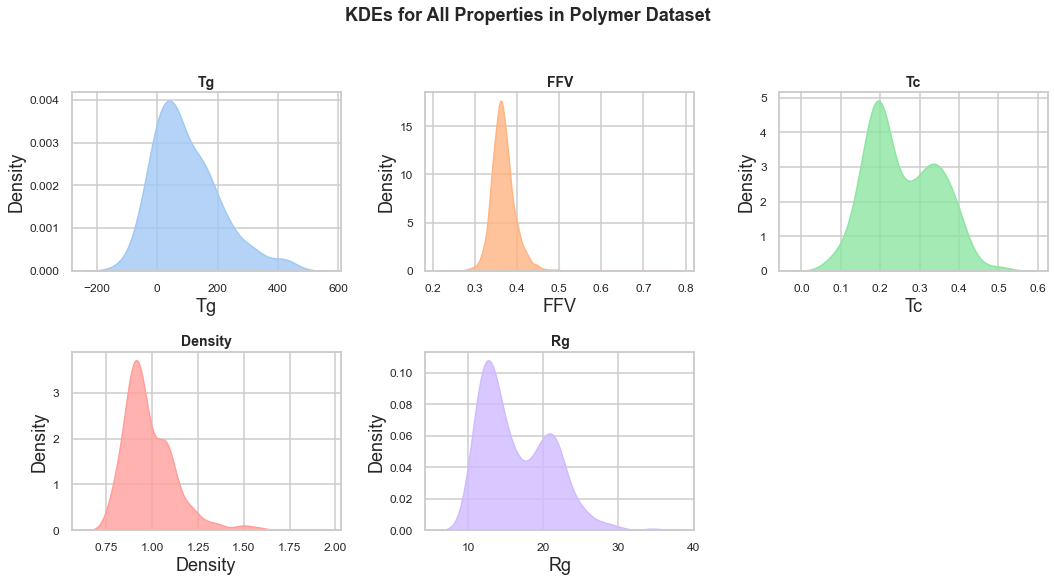

In [ ]:
sns.set(style="whitegrid", context="talk")

fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.flatten()

for i, prop in enumerate(properties):
    sns.kdeplot(
        data=property_to_df[prop],
        x=prop,
        fill=True,
        ax=axes[i],
        linewidth=1.5,
        alpha=0.8,
        color=sns.color_palette("pastel")[i % len(sns.color_palette("pastel"))]
    )
    axes[i].set_title(prop, fontsize=14, weight="bold")
    axes[i].set_xlabel(prop)
    axes[i].set_ylabel("Density")
    axes[i].tick_params(axis='both', which='major', labelsize=12)

for j in range(len(properties), len(axes)):
    fig.delaxes(axes[j])

fig.suptitle("KDEs for All Properties in Polymer Dataset", fontsize=18, weight="bold", y=1.02)

plt.tight_layout()
plt.show()

A couple of notes:

- Tg is very awkward - there are a lot of datapoints missing (93%), which is the most out of all the properties. Furthermore, there is a very large stdev relative to the mean, which worries me because this means there won't be enough examples of Tg in a particular "box" of a n-dimensional map of our feature space (i.e. most likely some curse of dimensionality will happen here, so feature selection of our model will be almost mandatory). However, as no model evaluation was done yet, I am not sure as to how easy it will be, because the distribution does not look too awkward from looking at the KDE. With that being said, I fear that chemical fingerprints will not work very well on glass temperature of polymers because according to this literature (https://www.nature.com/articles/s41467-020-14656-8), there is a correlation between Tg and packing length, which feels like a very "global" property. There is only one way to find out, I suppose.. Furthermore, from the skewness score in the summary_df (0.83) and visual inspection, there is some moderate skewness of the distribution towards the left-hand side. This needs to be accounted for when modeling, because skewness leads to a more biased model (in this case, model may become more biased towards lower Tg relative to the mean). One way we can address this is by choosing a more refined "stratified" way of sampling when we construct our training set to mitigate this. The kurtosis score is relatively healthy though - it's quite low (relative to a normal distribution), so no need to drop outliers here (at least relative to the label).
- FFV (fractional free volume) appears to be a global property, so we need to build a representation that can capture these long-range interactions well within n-monomers. Regardless, if we focus on the data itself, it has the least number of missing data points, which is already a good start! This is also reflected in the low variance. However, the problem lies in the skewness and the kurtosis - these two attributes worry me a lot. A skewness score of around 2 indicates that there is moderate skewing going on in the distribution, which means we can simply use 1.5IQR rule to trim outliers which isn't bad! However, if you look at the KDE of FFV, you may notice that it has.. a very long tail (from 0.5 to 0.8), hence the very large kurtosis score. This needs to be accounted for while modeling, because this will lead to tremendous bias in our model - either we use a different sampling technique, or we remove those values using some trimming technique.
- Tc (response to thermal conductivity) is probably a very local property, right? From my intuition about thermal conductivity, it's the rate of transfer in a lattice during the vibrations of neighboring atoms (i.e. very van der Waal dependent?) + energy transfer by free electrons, so I anticipate this to be well-predicted with chemical fingerprints. In any case, regarding the data, a lot of the comments are the same as Tg - many missing data points (we will be vulnerable to curse of dimensionality). However, as this is a bimodal distribution, the skewness score is actually relatively high, meaning that without proper sampling techniques or outlier removal, our model will become quite biased towards Tc values ranging from 0.1 to 0.23. The kurtosis score is relatively healthy - maybe some outlier removal needed, but nothing crazy because the tails aren't very long.
- Density will be relatively easy to predict with chemical fingerprints, because as long as we can capture spectral properties of the chemical graph, we should be fine. In any case, the comments about density are going to be relatively similar to the ones about FFV (apart from the fact that density has a lot of datapoints missing, whereas FFV does not) i.e. good variance. The skewness worries me though (slightly skewed to the left), but I think if we sample properly, it should be no problem - the skew is not a big deal. There is significant kurtosis though, so a lot of outlier removal will probably be needed, otherwise we'll have a model that has some unnecessary bias towards rho > 1.25.
- Rg (radius of gyaration) is the one I am most worried about when it comes to representation learning - this seems to be a very global property, as it is the distance between the COM of a polymer chain and its other components (https://fiveable.me/physical-chemistry-ii/unit-7/polymer-conformations-radius-gyration/study-guide/ZZkPanXFxDIZiVtt). In terms of the data itself, comments are virtually the exact same as Tg (apart from the stdev - there is a decently large stdev, but not to an extreme degree as Tg).

From outlier removal:

In [7]:
cleaned_prop_to_df = {}
outliers_removed = {}

for prop in properties:
    temp_df = property_to_df[prop]
    numeric_df = temp_df.select_dtypes(include=['number'])
    Q1 = numeric_df.quantile(0.25)
    Q3 = numeric_df.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    mask = ~((numeric_df < lower_bound) | (numeric_df > upper_bound)).any(axis=1)

    cleaned_prop_to_df[prop] = temp_df[mask]
    outliers_removed[prop] = len(temp_df) - mask.sum()

    print(f'For property {prop}, number of outliers removed = {outliers_removed[prop]} ({(1 - mask.sum()/len(temp_df)) * 100:.2f}%)')

For property Tg, number of outliers removed = 13 (2.54%)
For property FFV, number of outliers removed = 269 (3.83%)
For property Tc, number of outliers removed = 0 (0.00%)
For property Density, number of outliers removed = 21 (3.43%)
For property Rg, number of outliers removed = 2 (0.33%)


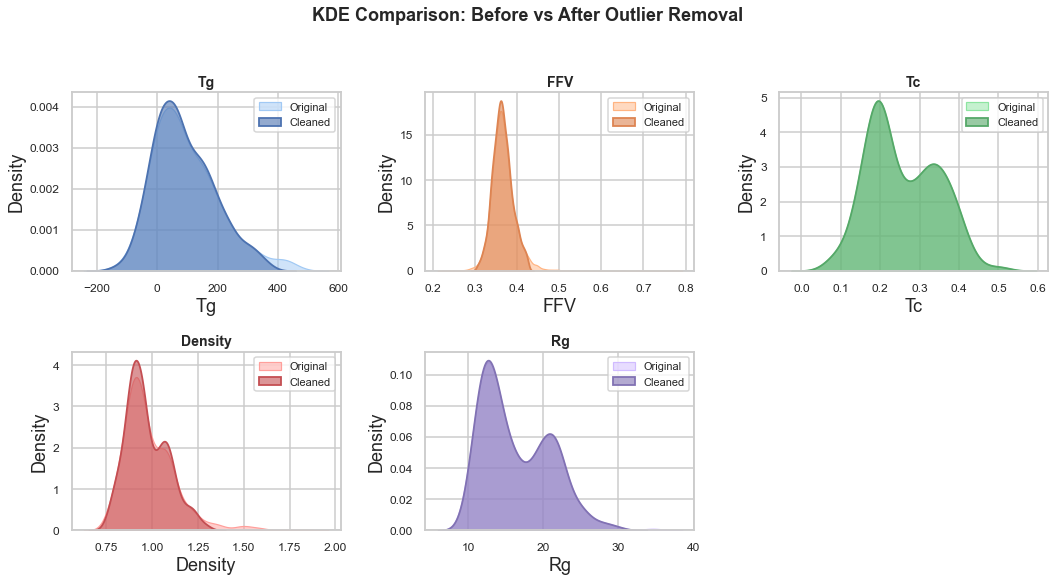

In [ ]:
sns.set(style="whitegrid", context="talk")

fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.flatten()

pastel = sns.color_palette("pastel")
bold = sns.color_palette("deep")

for i, prop in enumerate(properties):
    #no removed pts KDE
    sns.kdeplot(
        data=property_to_df[prop],
        x=prop,
        fill=True,
        ax=axes[i],
        linewidth=1.2,
        alpha=0.5,
        color=pastel[i % len(pastel)],
        label="Original"
    )

    #removed pts KDE
    sns.kdeplot(
        data=cleaned_prop_to_df[prop],
        x=prop,
        fill=True,
        ax=axes[i],
        linewidth=1.8,
        alpha=0.6,
        color=bold[i % len(bold)],
        label="Cleaned"
    )

    axes[i].set_title(prop, fontsize=14, weight="bold")
    axes[i].set_xlabel(prop)
    axes[i].set_ylabel("Density")
    axes[i].tick_params(axis='both', which='major', labelsize=12)
    axes[i].legend(frameon=True, fontsize=11)

for j in range(len(properties), len(axes)):
    fig.delaxes(axes[j])

fig.suptitle("KDE Comparison: Before vs After Outlier Removal", fontsize=18, weight="bold", y=1.02)

plt.tight_layout()
plt.show()

Some notes after outlier removal
- It's a little hard to see, but you can tell the huge impact it had in terms of the tail trimming for FFV, density and Rg
- The range of the distribution for these three properties has significantly shrunk, with FFV showing the biggest change of them all.
- Furthermore, the removal of outliers seems to improve the distribution for Tg in particular - there is a thick tail on the right-hand side of the distribution which have been removed. This is important, because there were many outliers at the end of the tail, which would make the model more biased.

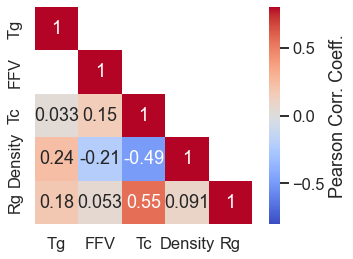

In [8]:
corr_pairwise = df[properties].corr(method='pearson', min_periods=1)
mask = np.triu(np.ones_like(corr_pairwise, dtype = bool), k = 1)

sns.heatmap(corr_pairwise, annot=True, cmap="coolwarm", vmin=-0.8, vmax=0.8, square = True, mask = mask, cbar_kws = {"label" : "Pearson Corr. Coeff."})
plt.show()

Some notes about the correlation between different labels:
- Thermal conductivity vs density: there is a slight inverse correlation between the two. This is... interesting, to say the least, as I fully expected a direct proportionality relationship between the two. In materials, if it is more closely packed, it means energy transfer between atoms is faster (as it is done through vibrations), thus making the thermal conductivity higher. This is very peculiar, and I have no explanation for this. I don't think this is a statistically insignificant reason too, because 535 data points are in common between Tc and density.
- FFV and density have a slight inverse proportionality. which I expected to be a stronger correlation. FFV means the amount of empty space in a polymer, and as a result, more FFV means less dense polymer. However, the trend makes sense.
- Very interestingly, radius of gyration has a decently strong positive correlation with thermal conductivity. Correlation explained here: https://www.nature.com/articles/s41524-023-01154-w#:~:text=The%20high%20TC%20polymer%20structures,of%20polymers%20with%20desirable%20properties. 
- The other entries in the matrix show insignicant or weak correlations. There is a missing entry between Tg and FFV - this is because there is only one datapoint (i.e. SRCC = nan).

#### <b>Featurizer</b>

DO NOT RUN! This is a little computationally expensive (took 2 minutes to calculate on my office PC).

In [11]:
results = []
for i, smi in enumerate(tqdm(df['canonical_smiles'], desc = "calculating descriptors...")):
    summary = Featurizer(smi = smi).summary_of_results()
    summary["SMILES"] = df["SMILES"].tolist()[i]
    summary["canonical_smiles"] = df["canonical_smiles"].tolist()[i]
    results.append(summary)

calculating descriptors...: 100%|██████████| 7973/7973 [01:58<00:00, 67.12it/s] 


In [12]:
df_descriptors = pd.DataFrame(results)
all_descriptors = df_descriptors.columns[:-2].tolist()
df_descriptors = df_descriptors[["SMILES", "canonical_smiles"] + all_descriptors]
df_descriptors

SMILES  \
0                            *CC(*)c1ccccc1C(=O)OCCCCCC   
1     *Nc1ccc([C@H](CCC)c2ccc(C3(c4ccc([C@@H](CCC)c5...   
2     *Oc1ccc(S(=O)(=O)c2ccc(Oc3ccc(C4(c5ccc(Oc6ccc(...   
3     *Nc1ccc(-c2c(-c3ccc(C)cc3)c(-c3ccc(C)cc3)c(N*)...   
4     *Oc1ccc(OC(=O)c2cc(OCCCCCCCCCOCC3CCCN3c3ccc([N...   
...                                                 ...   
7968       *Oc1cc(CCCCCCCC)cc(OC(=O)c2cccc(C(*)=O)c2)c1   
7969  *C(=O)OCCN(CCOC(=O)c1ccc2c(c1)C(=O)N(c1cccc(N3...   
7970  *c1cc(C(=O)NCCCCCCCC)cc(N2C(=O)c3ccc(-c4ccc5c(...   
7971                                   *C=C(*)c1ccccc1C   
7972  *c1ccc(OCCCCCCCCCCCOC(=O)CCCCC(=O)OCCCCCCCCCCC...   

                                       canonical_smiles  MaxAbsEStateIndex  \
0                            *CC(*)c1ccccc1C(=O)OCCCCCC          12.144536   
1     *Nc1ccc([C@H](CCC)c2ccc(C3(c4ccc([C@@H](CCC)c5...           3.523412   
2     *Oc1ccc(S(=O)(=O)c2ccc(Oc3ccc(C4(c5ccc(Oc6ccc(...          13.714745   
3     *Nc1ccc(-c2c(-c3ccc(C)cc3)c(-c3ccc(C)cc3)c(N*)...           3.978671   
4     *Oc1ccc(OC(=O)c2cc(OCCCCCCCCCOCC3CCCN3c3ccc([N...          13.703218   
...                                                 ...                ...   
7968       *Oc1cc(CCCCCCCC)cc(OC(=O)c2cccc(C(*)=O)c2)c1          12.522270   
7969  *C(=O)OCCN(CCOC(=O)c1ccc2c(c1)C(=O)N(c1cccc(N3...          13.679392   
7970  *c1cc(C(=O)NCCCCCCCC)cc(N2C(=O)c3ccc(-c4ccc5c(...          13.555573   
7971                                   *C=C(*)c1ccccc1C           2.502315   
7972  *c1ccc(OCCCCCCCCCCCOC(=O)CCCCC(=O)OCCCCCCCCCCC...          12.020227   

      MaxEStateIndex  MinAbsEStateIndex  MinEStateIndex       qed        SPS  \
0          12.144536           0.105927       -0.105927  0.500278  13.705882   
1           3.523412           0.098918        0.098918  0.125364  16.777778   
2          13.714745           0.107441       -3.829434  0.092387  16.301370   
3           3.978671           0.054569       -0.202102  0.209590  11.523810   
4          13.703218           0.068062       -0.686332  0.014164  15.885714   
...              ...                ...             ...       ...        ...   
7968       12.522270           0.172388       -0.436195  0.311026  11.423077   
7969       13.679392           0.005765       -0.729725  0.044063  13.714286   
7970       13.555573           0.193809       -0.612298  0.313025  14.897436   
7971        2.502315           0.396204        0.396204  0.528143  14.555556   
7972       12.020227           0.116434       -0.153796  0.046481  11.529412   

         MolWt  HeavyAtomMolWt  ...  wiener_index  hyper_wiener_index  \
0      232.323         212.163  ...         810.0                 386   
1      598.919         544.487  ...        9042.0                1174   
2     1003.207         952.807  ...       42790.0                2056   
3      542.726         508.454  ...        5680.0                1188   
4      965.154         896.610  ...       39988.0                1668   
...        ...             ...  ...           ...                 ...   
7968   352.430         328.238  ...        2425.0                 616   
7969   750.680         724.472  ...       18214.0                1558   
7970   521.573         494.357  ...        6587.0                1108   
7971   116.163         108.099  ...         152.0                 236   
7972   721.017         660.537  ...       22079.0                1062   

        kappa1     kappa2       kappa3  spectral_radius  number_of_cycles  \
0     1.117647   8.052632   185.785714         2.347213                 1   
1     1.133333  20.294118   980.526316         2.512983                 5   
2     1.150685  32.154762  2434.234568         2.494566                10   
3     1.166667  18.428571   774.000000         2.598093                 6   
4     1.100000  32.272727  2761.111111         2.425533                 6   
...        ...        ...          ...              ...               ...   
7968  1.115385  12.103448 

In [13]:
df_descriptors.to_csv("RDKit_topological.csv", index = False)

<b>Start running code again from here!</b>

In [9]:
df_descriptors = pd.read_csv("RDKit_topological.csv")
df_descriptors = df_descriptors.dropna(axis = 1) # some columns are NaN (a few RDKit descriptors)
property_to_features_and_label = {}

for prop in properties:
    temp_df = cleaned_prop_to_df[prop]
    df_concat = df_descriptors.merge(temp_df, how = 'inner', on = 'SMILES')
    property_to_features_and_label[prop] = df_concat

We initially started with 218 descriptors and ended with 206 descriptors after doing ```df_descriptors.dropna(axis = 1)```. The following descriptors were dropped: 
```
{'BCUT2D_CHGHI',
 'BCUT2D_CHGLO',
 'BCUT2D_LOGPHI',
 'BCUT2D_LOGPLOW',
 'BCUT2D_MRHI',
 'BCUT2D_MRLOW',
 'BCUT2D_MWHI',
 'BCUT2D_MWLOW',
 'MaxAbsPartialCharge',
 'MaxPartialCharge',
 'MinAbsPartialCharge',
 'MinPartialCharge'}
 ```
 
 This is most likely due to how the descriptor calculations were set up. For example, let us take a look at MaxAbsPartialCharge - because the SMILES have an asterix in them to denote periodicity of the polymers rather than an actual atom, a charge calculation was most likely attempted on this dummy atom and (obviously) failed, leading to NaN values for these columns. This can, of course, be fixed by replacing the asterix with a dummy [H] atom that has very little impact on the actual calculations while not raising an error.

#### <b>Baseline ML results</b>

This is just a proof-of-concept. We don't need it in the proposal, but this is just to check if our descriptors are meaningful for these tasks. :)

In [10]:
# some baseline results if you're interested... :)
for property in properties:
    #property = "FFV"
    temp_df = property_to_features_and_label[property].dropna(axis = 1)
    descriptor_names = [x for x in temp_df.columns if x not in [property, "SMILES", "canonical_smiles"]]
    temp_df = temp_df[descriptor_names + [property]]
    temp_df = temp_df.clip(upper = 1e6)

    X, y = temp_df[descriptor_names].to_numpy(), temp_df[property].to_numpy()

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    model = xgb.XGBRegressor(n_estimators = 400)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    print(f'For property {property}, SRCC = {spearmanr(y_test, y_pred)[0]}, MAE = {mean_absolute_error(y_test, y_pred)}')

For property Tg, SRCC = 0.7417101710171017, MAE = 48.928065258712486
For property FFV, SRCC = 0.9320380195204119, MAE = 0.00582686554119237
For property Tc, SRCC = 0.8843974344768314, MAE = 0.02959679722108104
For property Density, SRCC = 0.9165875882858644, MAE = 0.03099544800308279
For property Rg, SRCC = 0.8163315319033677, MAE = 1.7865429719017005


#### <b>Feature-Label Correlations</b>

In [11]:
topological_descriptors = ['balaban_index', 'wiener_index', 'hyper_wiener_index', 'spectral_radius',
                           'number_of_cycles', 'number_of_stars', 'diameter', 'number_of_branches'
                           ]

rdkit_descriptors = [x for x in df_descriptors.columns.tolist() if x not in topological_descriptors + ['SMILES', 'canonical_smiles', 'Kappa1', 'Kappa2', 'Kappa3']]

c:\Users\sarta\anaconda3\lib\site-packages\scipy\stats\_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


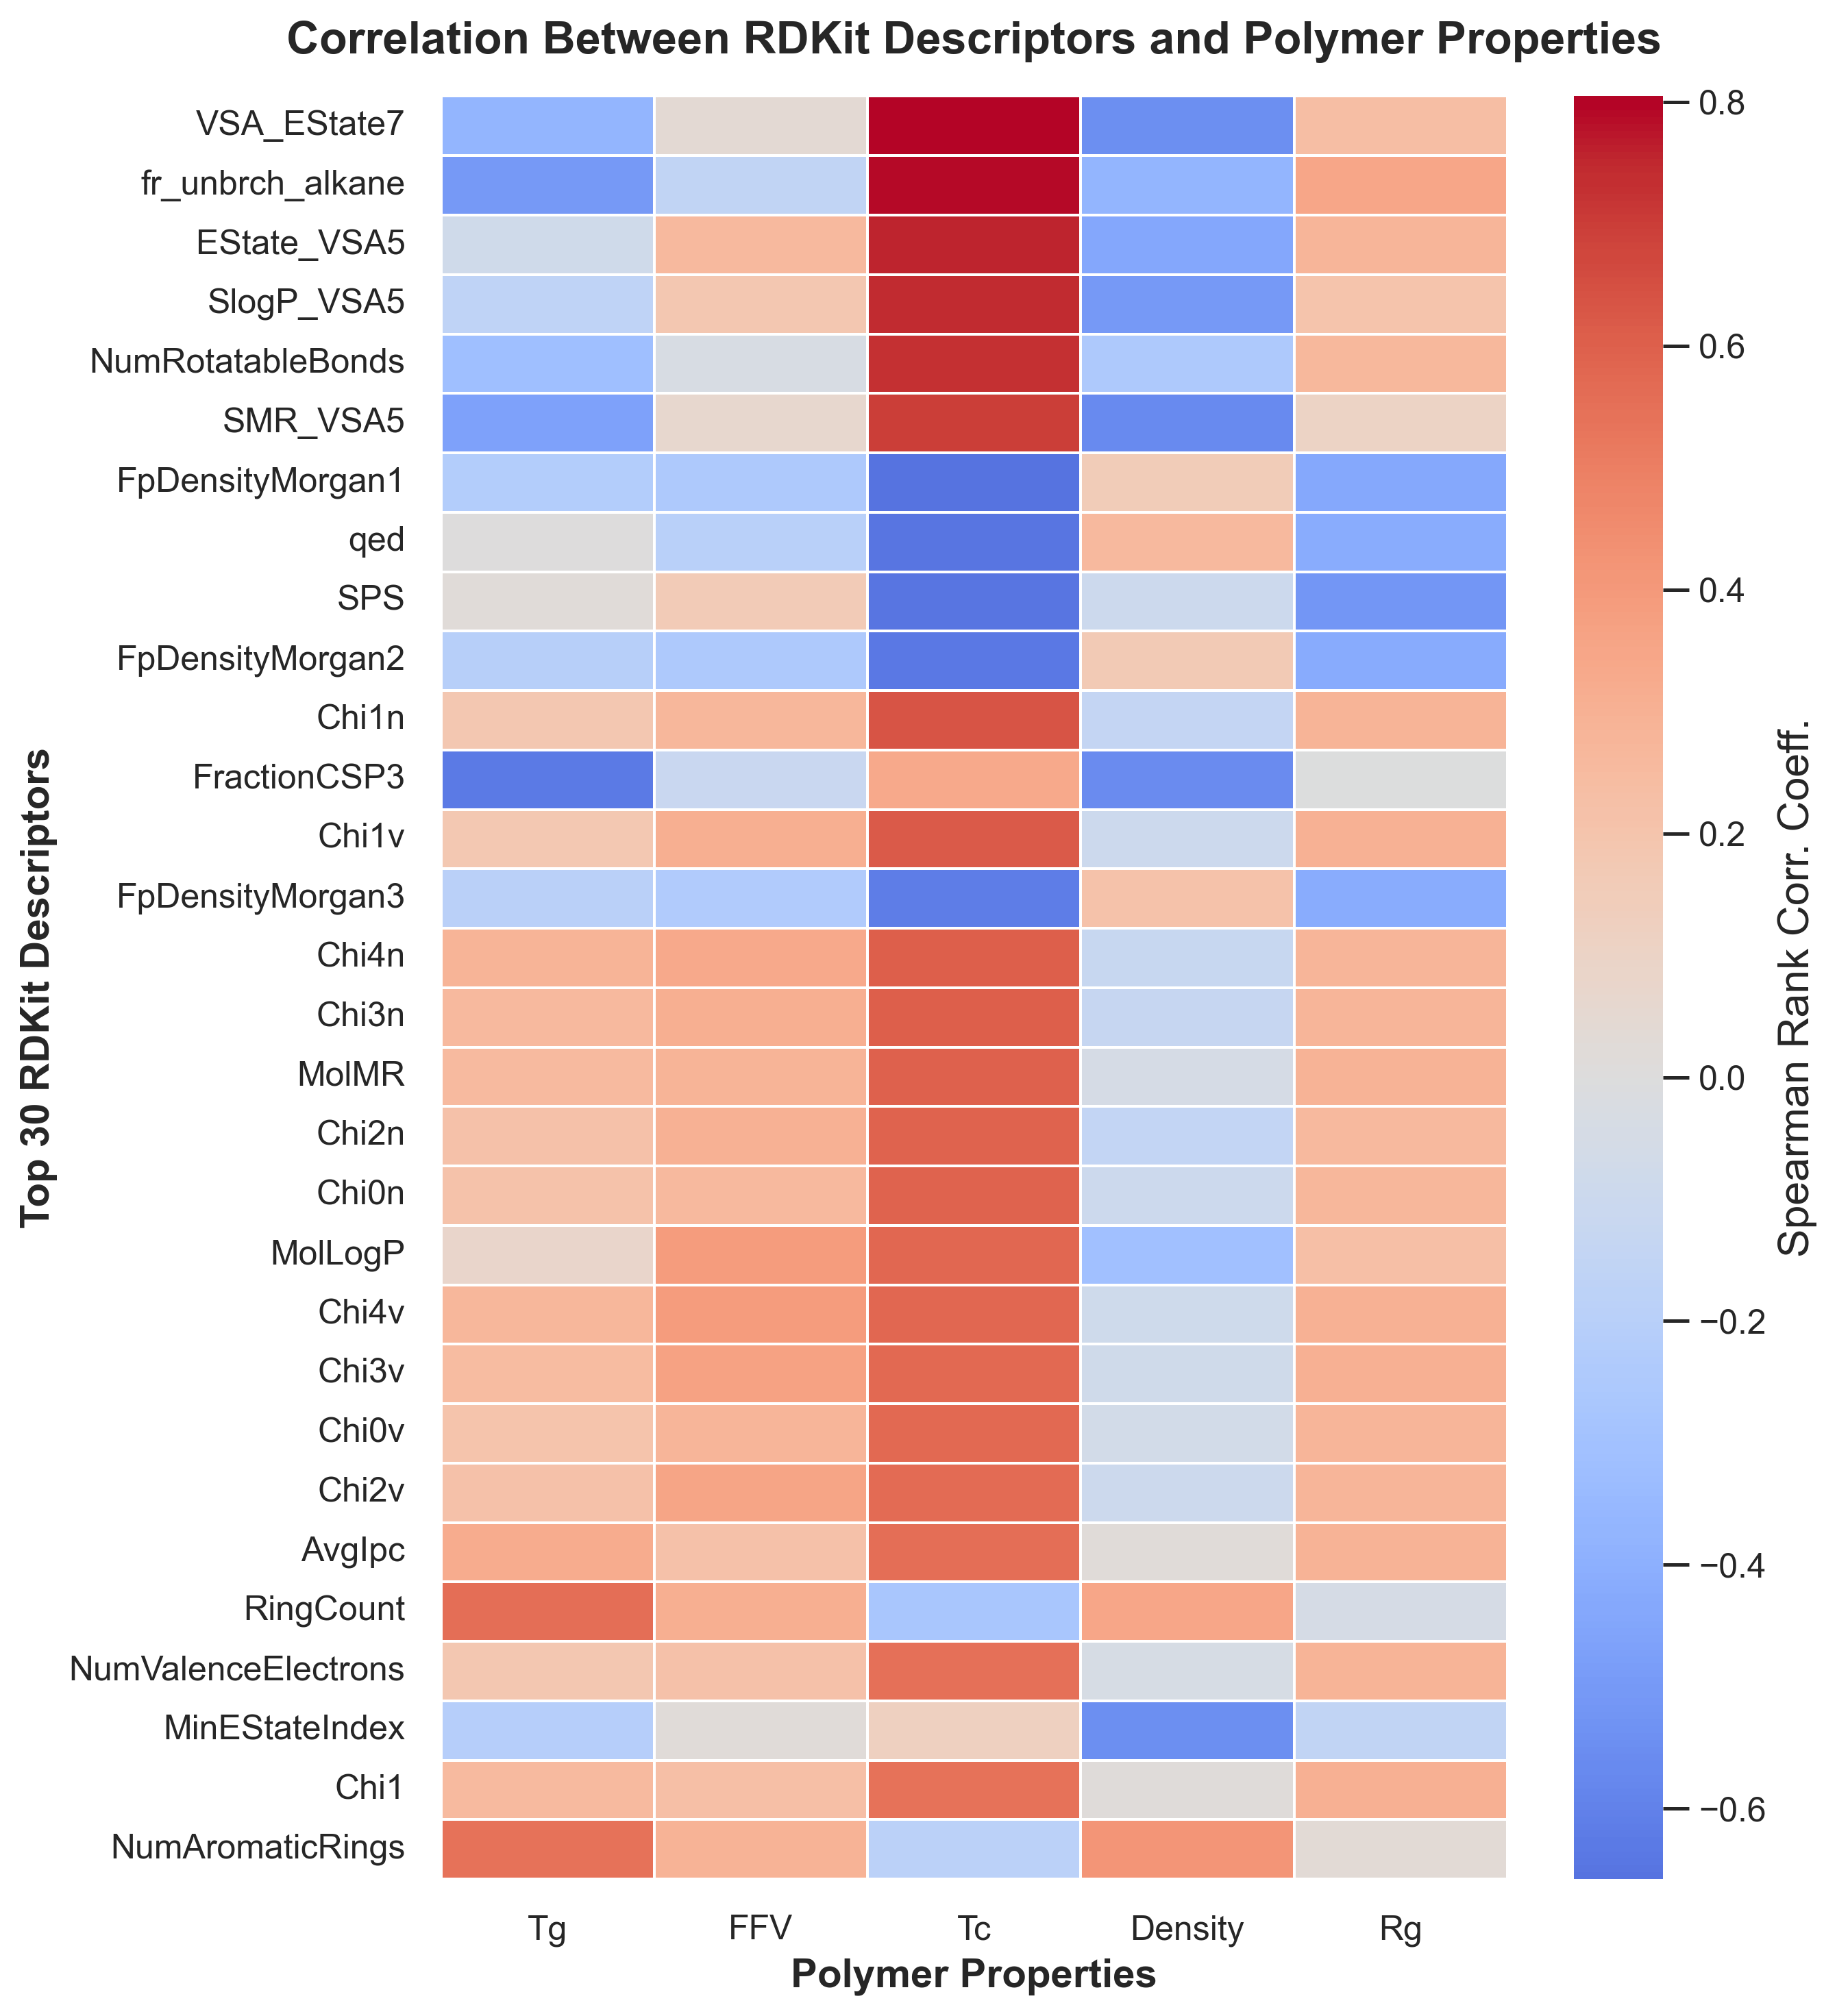

In [13]:
#feature --> label correlation matrix (RDKit descriptors only!)

property_to_feature_srcc = {"Tg" : [], "FFV" : [], "Tc" : [], "Density" : [], "Rg" : []}

for prop in property_to_feature_srcc.keys():
    for name in rdkit_descriptors:
        x1 = property_to_features_and_label[prop][name].tolist()
        x2 = property_to_features_and_label[prop][prop].tolist()
        property_to_feature_srcc[prop].append(spearmanr(x1, x2)[0])

srcc_matrix = pd.DataFrame(property_to_feature_srcc, index = rdkit_descriptors)
srcc_matrix["importance"] = srcc_matrix.abs().max(axis = 1)
srcc_matrix_sorted = srcc_matrix.sort_values("importance", ascending = False)

# --- Sort and extract top N ---
topN = 30
df_top = (
    srcc_matrix_sorted.iloc[:topN, :-1]
    .reset_index(drop=False)
    .set_index("index")
)

# --- Styling ---
sns.set_theme(style="whitegrid", context="talk")
plt.rcParams.update({
    "font.size": 13,
    "axes.labelsize": 15,
    "axes.titlesize": 16,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
    "axes.linewidth": 1.2,
    "xtick.major.width": 1.2,
    "ytick.major.width": 1.2,
    "figure.dpi": 300,
    "savefig.dpi": 300
})

# --- Figure ---
fig, ax = plt.subplots(figsize=(9, 10))

# --- Heatmap ---
sns.heatmap(
    df_top,
    cmap="coolwarm",
    annot=False,                # show numeric SRCCs
    fmt=".2f",
    linewidths=0.5,
    linecolor="white",
    cbar_kws={"label": "Spearman Rank Corr. Coeff."},
    center=0,
    square=False,
    ax=ax
)

# --- Axis formatting ---
ax.set_xlabel("Polymer Properties", fontsize=14, weight="bold")
ax.set_ylabel(f"Top {topN} RDKit Descriptors", fontsize=14, weight="bold")

# Ensure all descriptor labels appear
ax.set_yticks([i + 0.5 for i in range(len(df_top.index))])
ax.set_yticklabels(df_top.index, rotation=0, va="center")

# Rotate x labels for readability
plt.xticks(rotation=0)

# --- Add title (optional) ---
plt.title("Correlation Between RDKit Descriptors and Polymer Properties", fontsize=16, weight="bold", pad=15)

plt.tight_layout()
plt.show()

From this, a few observations can be made:
- For Tc, there are many strongly correlated features with it, which means that our representation for Tc is sufficient enough for good property predictions - even at a low data regime. It will converge to a solution fast.
- Similarly for density, not only is this generally an easy task in materials, but it has strong features that it correlates with such as MinEStateIndex, FractionCSP, etc. 
- FFV has many weakly correlated features, but the model will not suffer from the curse of dimensionality because these features will "accumulate" together to make a good number of data points, and FFV is the only label with many datapoints (N = around 7000)
- Tg will be a very tricky label to predict; while it has weakly correlated features like FFV, the problem is that with so many weakly correlated features and very few data points, Tg will suffer from the curse of dimensionality. As such, there are two paths we can take here: (1) we do feature selection so that we get away from the curse of dimensionality problem, or (2) we engineer more meaningful, compact features. We can probably do this by taking linear combinations or multiply features together, if you want a very dummy solution. Alternatively, we need to look into the physical meaning behind glass temperature, as it is dependent on both chemistry and global environment (I think?)

c:\Users\sarta\anaconda3\lib\site-packages\scipy\stats\_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


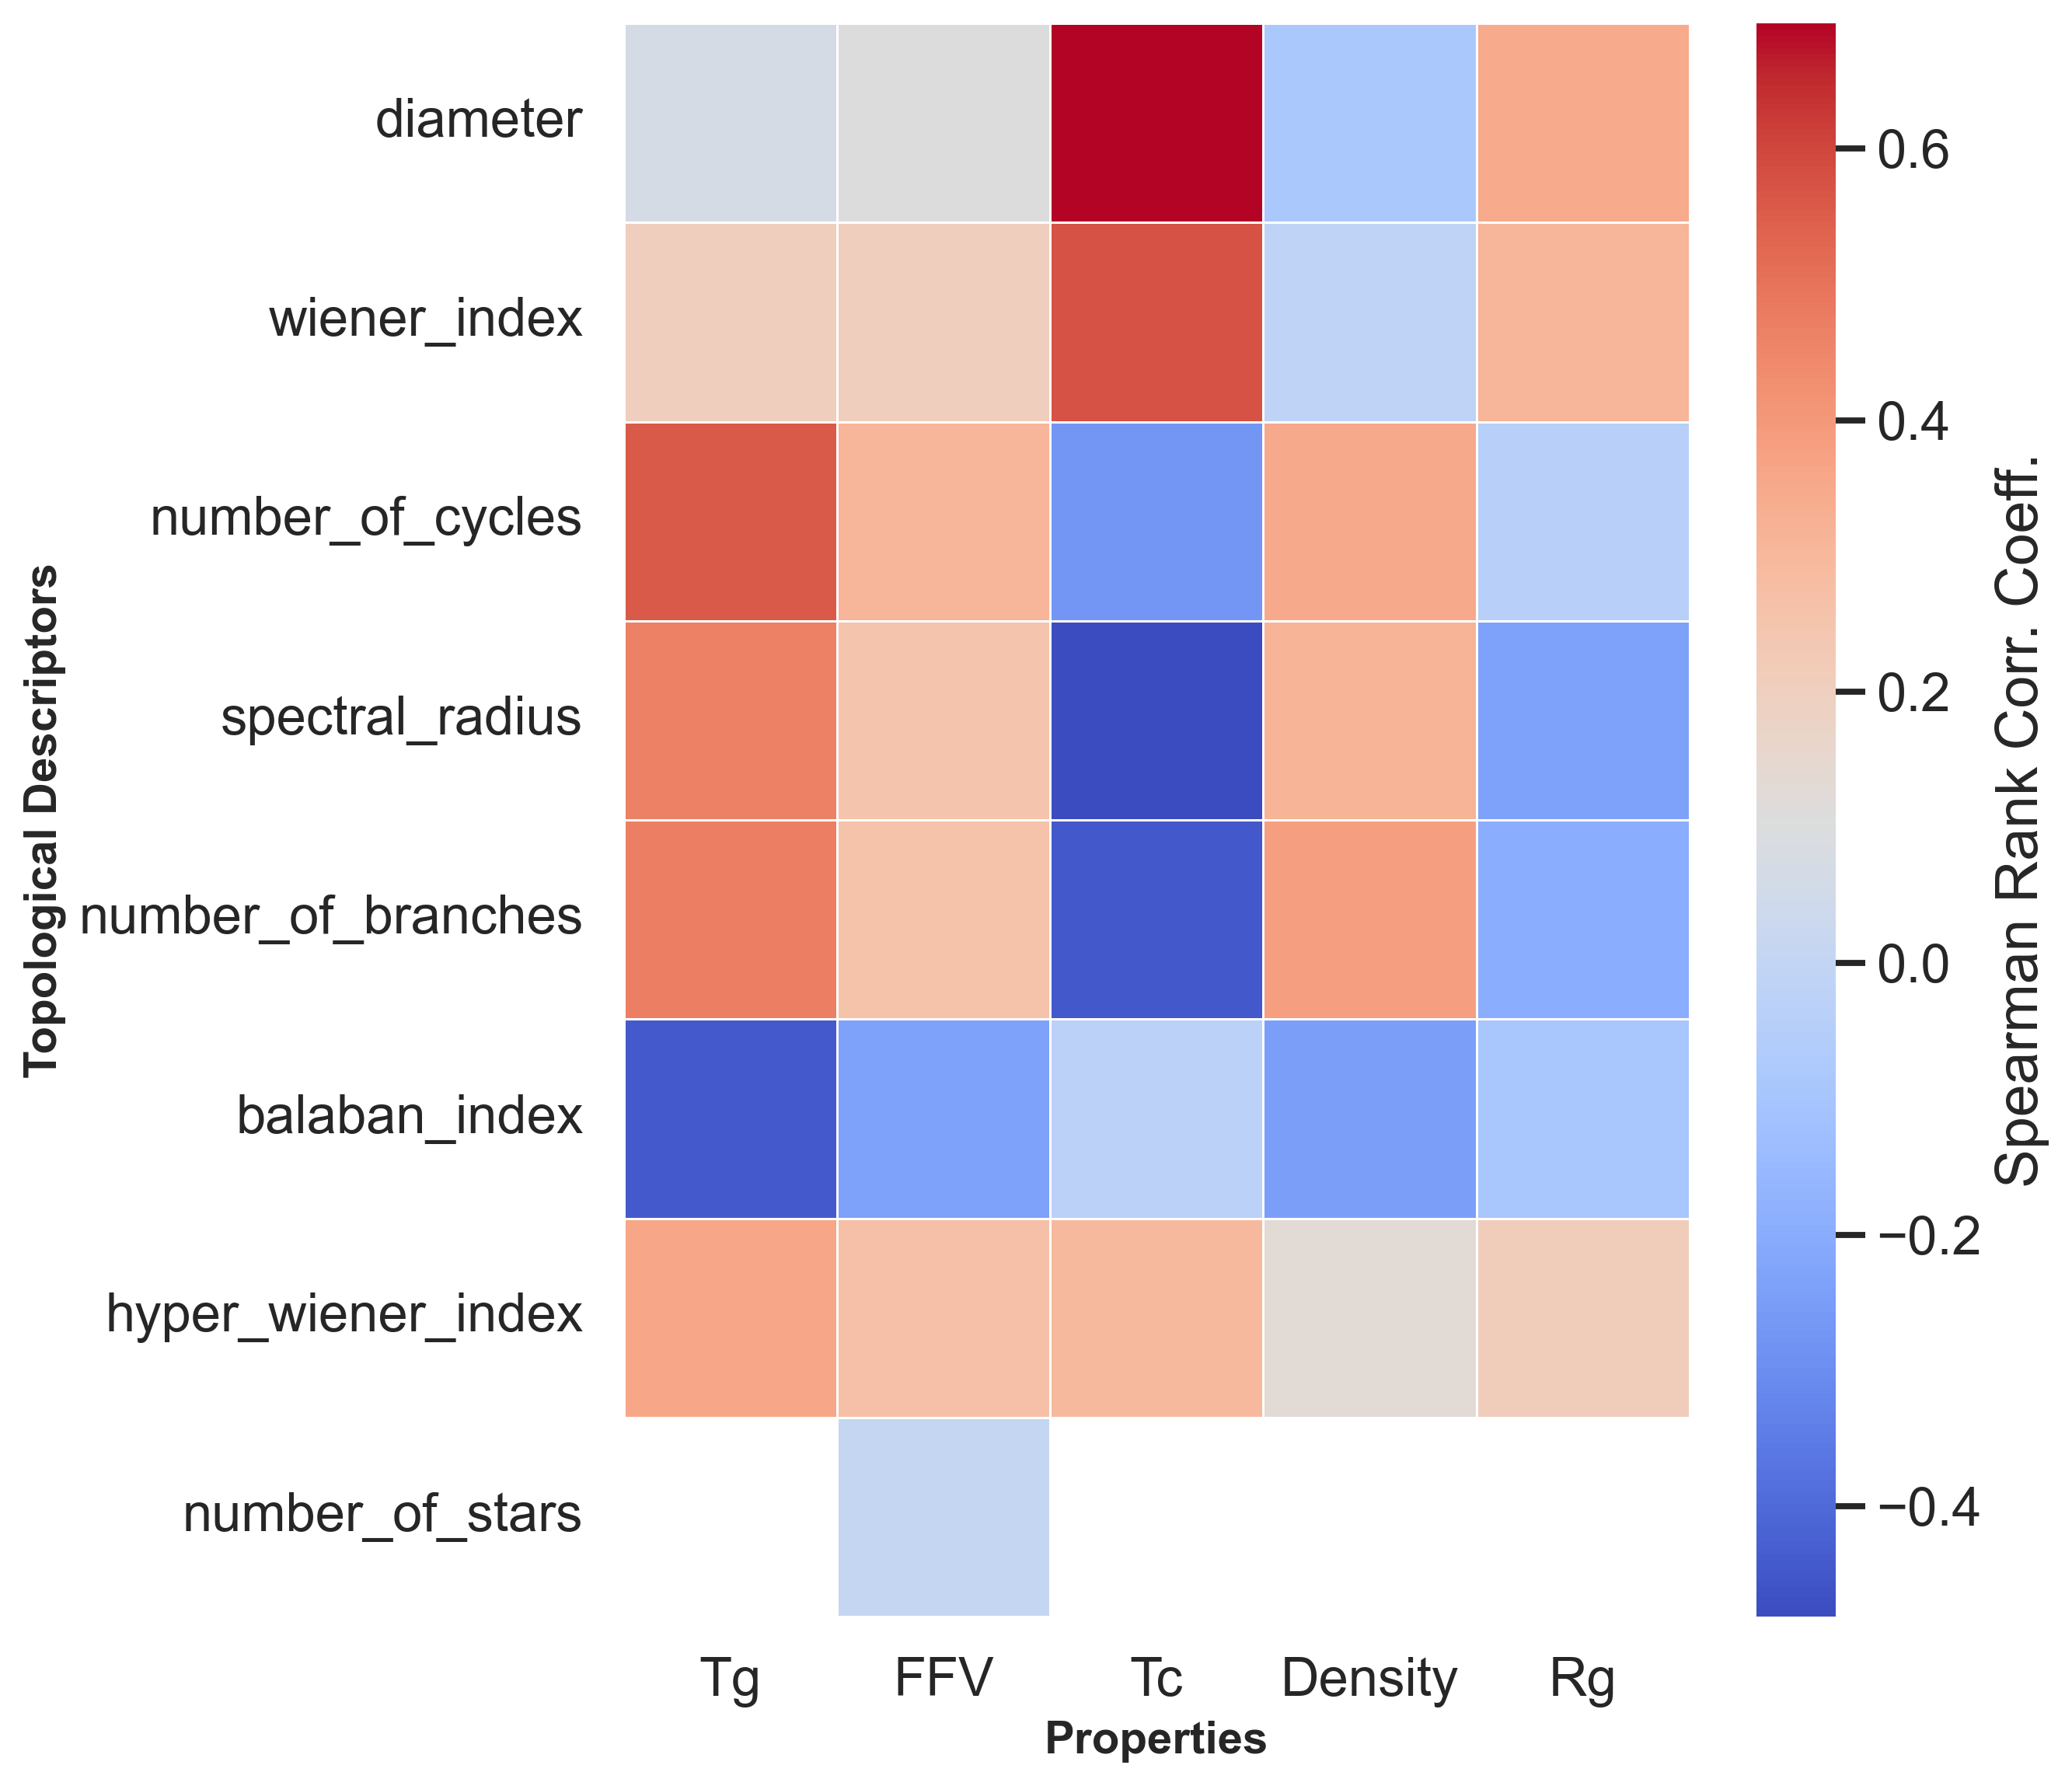

In [14]:
property_to_feature_srcc = {"Tg" : [], "FFV" : [], "Tc" : [], "Density" : [], "Rg" : []}

for prop in property_to_feature_srcc.keys():
    for name in topological_descriptors:
        x1 = property_to_features_and_label[prop][name].tolist()
        x2 = property_to_features_and_label[prop][prop].tolist()
        property_to_feature_srcc[prop].append(spearmanr(x1, x2)[0])

srcc_matrix = pd.DataFrame(property_to_feature_srcc, index = topological_descriptors)
srcc_matrix["importance"] = srcc_matrix.abs().max(axis = 1)
srcc_matrix_sorted = srcc_matrix.sort_values("importance", ascending = False)

topN = 8
df_top = srcc_matrix_sorted.iloc[:topN, :-1]
df_top = df_top.reset_index(drop=False)
df_top = df_top.set_index("index")
sns.set_theme(style="whitegrid", context="talk")
plt.figure(figsize=(9, 8))
ax = sns.heatmap(
    df_top,
    cmap="coolwarm",
    annot=False,
    fmt=".2f",
    linewidths=0.6,
    cbar_kws={"label": "Spearman Rank Corr. Coeff."},
    square=False
)
# --- Force all descriptor names to appear ---
ax.set_yticks([i + 0.5 for i in range(len(df_top.index))])
ax.set_yticklabels(df_top.index, rotation=0, va="center")
# --- Aesthetic polish ---
ax.set_xlabel("Properties", fontsize=14, weight="bold")
ax.set_ylabel("Topological Descriptors", fontsize=14, weight="bold")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

- number_of_stars (number of asterix in SMILES string of polymer) will probably be dropped from all labels.. There is very little to no correlation with every label, apart from a weak correlation with FFV
- Diameter of graph (as we are working with undirected graphs, maximum eccentricity) measures the longest distance between two nodes (which is a good way of measuring backbone length of polymer from a graph perspective). With a longer body, the results suggest that it has a very strong positive correlation with thermal conductivity of polymer. This will be an important feature. However, it does not add much to Tg (which.. makes sense to me I think, Tg is about intermolecular interactions, and diameter is a very global property). It adds a little to the other features.
- For the same logic, Wiener and Hyper Wiener index are positively correlated with every label besides density. This makes sense - if there are larger distances between atoms, this means the material is going to be less packed together.
- Spectral radius is a measure of how well-connected and dense a polymer graph is (i.e., there is a positive correlation between spectral radius and density). With thermal conductivity, there is a very strong inverse correlation with thermal conductivity - while this does not make sense to me on a physical perspective (it should be a positive correlation, because more packed means energy transfers easier), the label-to-label correlation matrix suggested that there is an inverse correlation between Tc and density - which I commented on that it does not make sense to me physically. Spectral radius also adds to radius of gyration, and to me, the correlation makes sense. Rg generally increases if the chain is more extended (i.e. lower density and thus, lower spectral radius) and vice versa. For Tg, it does not seem to add much.
- Balaban index has a very strong inverse correlation with Tg, which will be important as this is an inherently difficult property. For a physical intuition, Balaban index can be considered the "inverse" of Wiener index (i.e. inverse square root distances between nodes (u, v)). As a result, it makes sense that it has an inverse correlation with all the labels that had a positive correlation with Wiener index. Density is an interesting case though, because I expected a direct correlation between this index and density, which is the opposite case. However, the correlation score is quite weak for both Wiener index and Balaban index, so it shouldn't matter too much during feature selection.
- When looking at the number of branches in the polymer, it immediately makes sense why it has an inverse relationship with Rg; Rg increases for more linear polymers, and branches interfere with linearity - thus, more branches should lead to lower Rg. This descriptor is also informative for Tg; from my intuition, glass temperature should increase if it is more difficult for the chain to be mobile (because it will require more energy). Branches will interfere with chain mobility, so this is a very expected correlation. I honestly did not expect a positive correlation with FFV (it should be the other way around?), but the positive correlation with density makes total sense to me - more chains means a more dense framework.

#### <b>Feature-Feature Correlations</b>

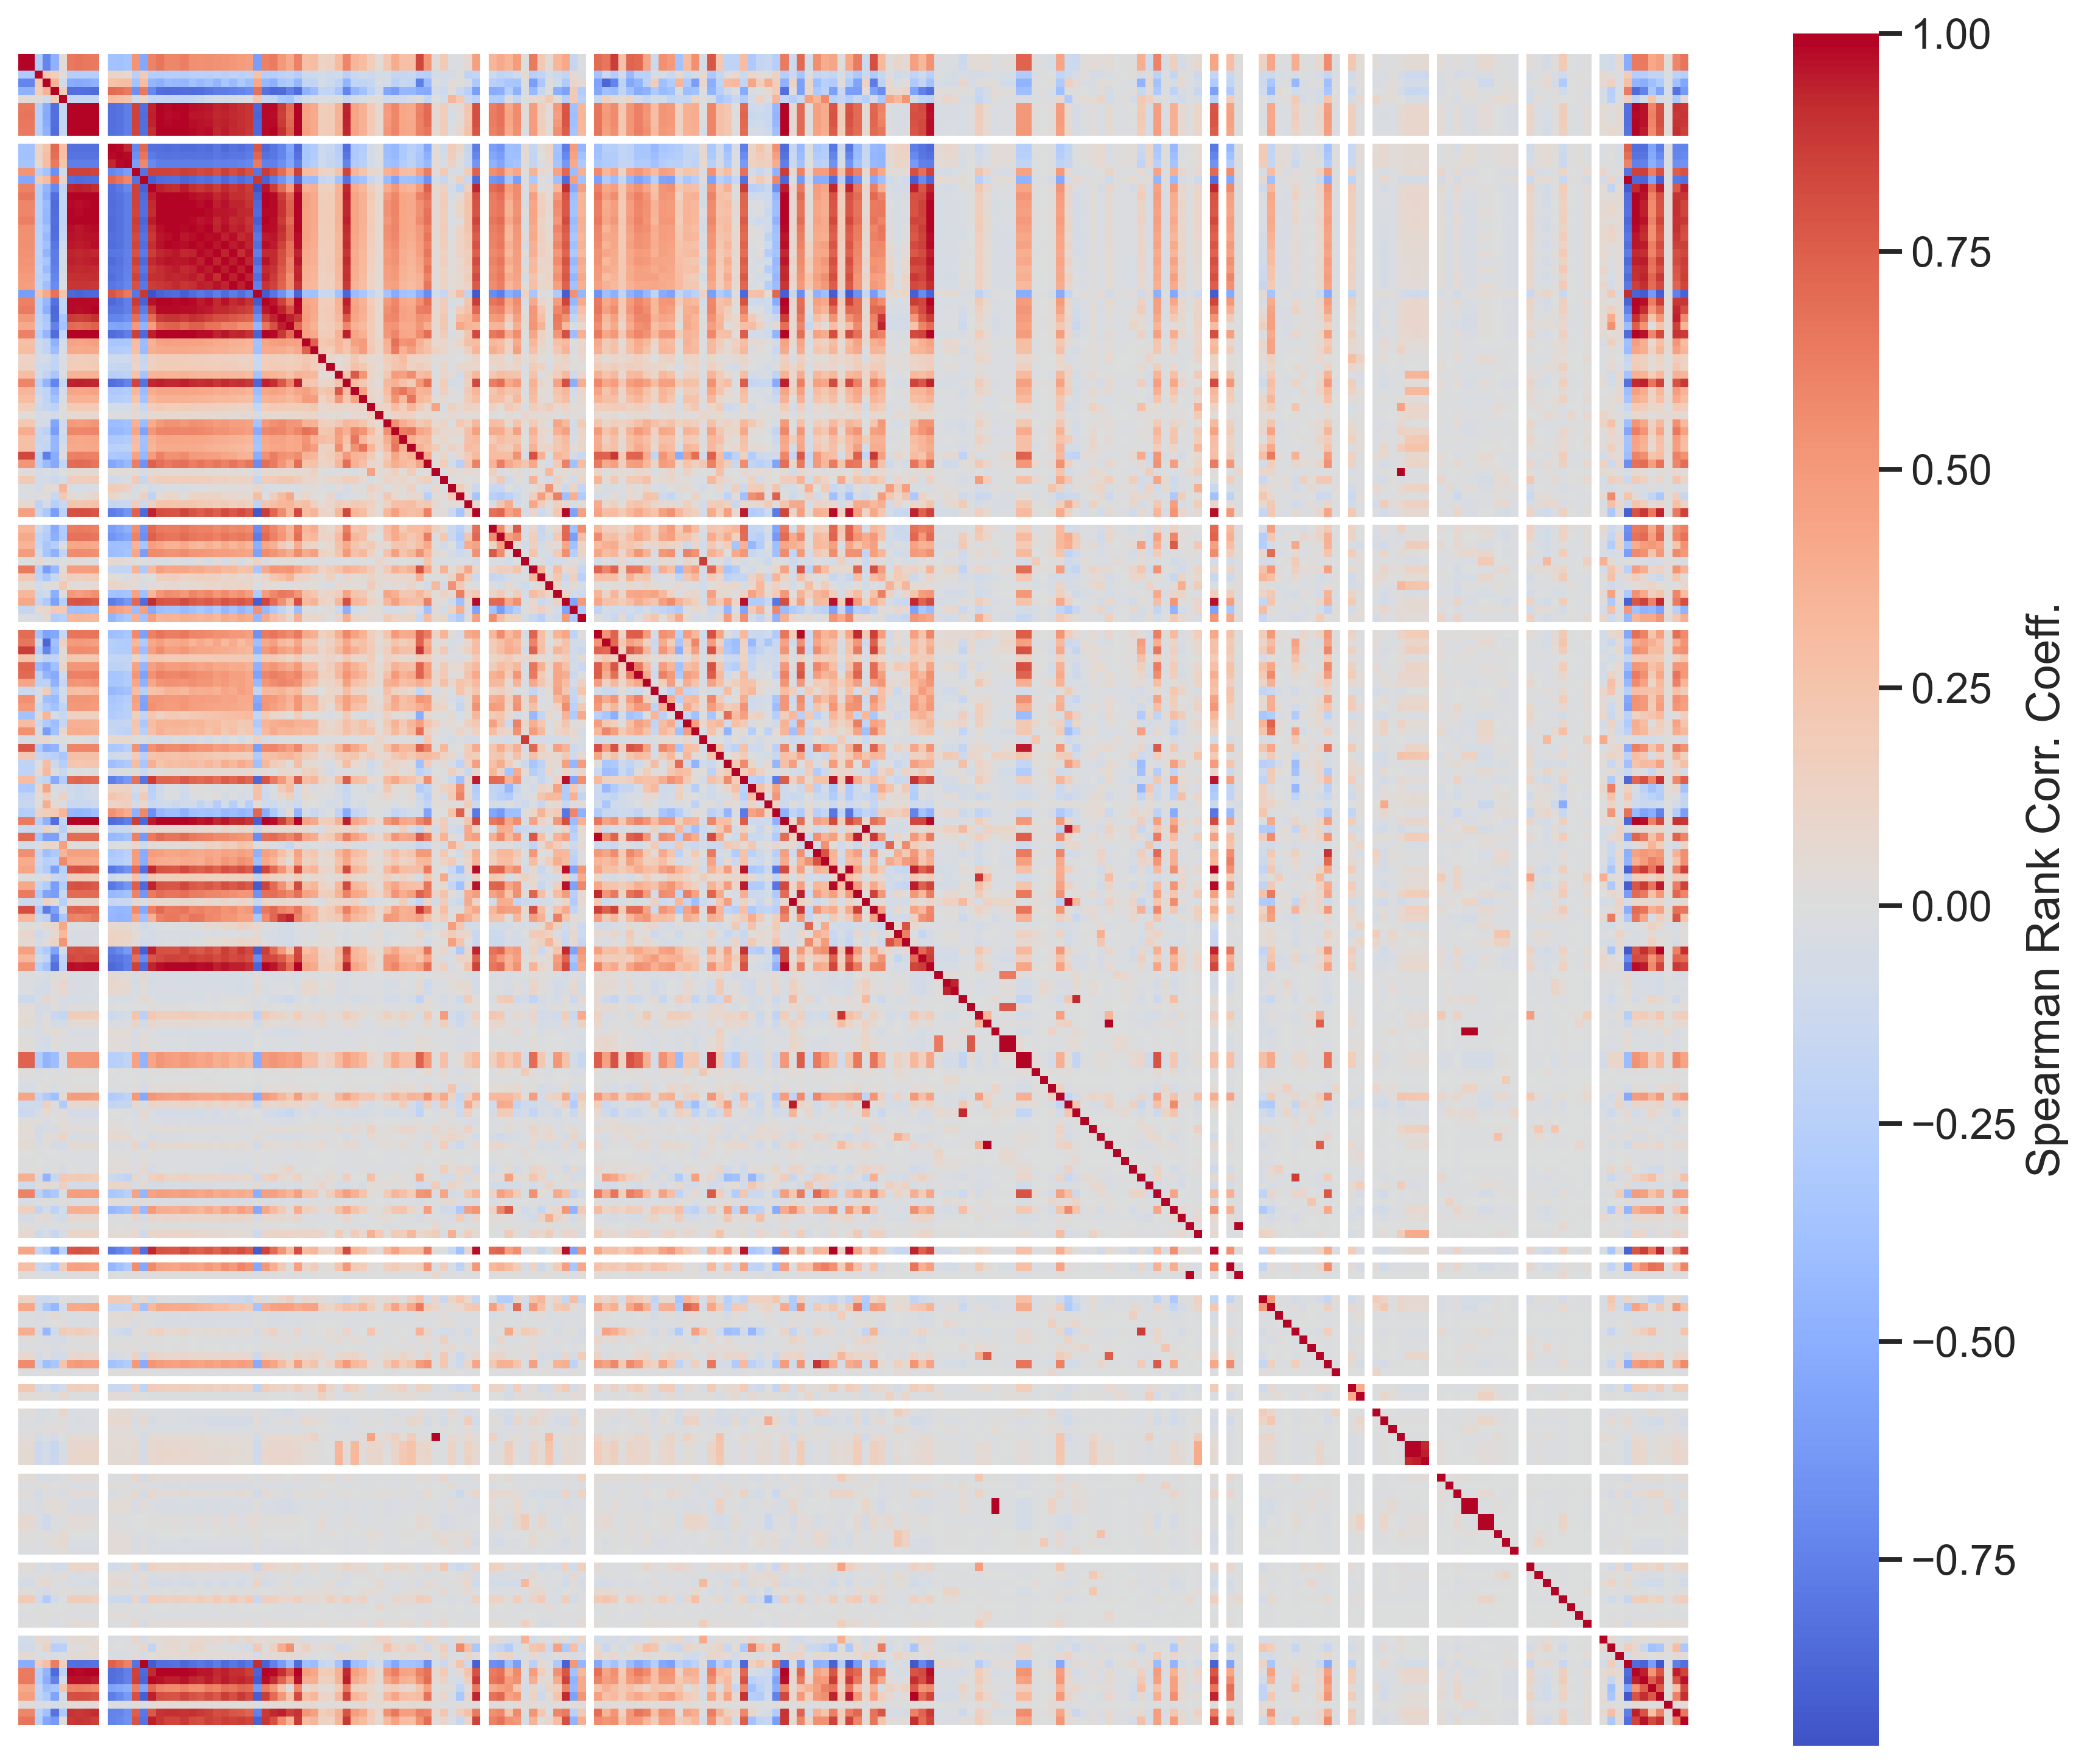

In [18]:
#which features are redundant?
df_descriptors_with_dropped_cols = df_descriptors.dropna(axis = 1)
all_descriptor_names = df_descriptors.dropna(axis = 1).columns[2::].tolist()
corr_features = df_descriptors_with_dropped_cols[all_descriptor_names].corr(method = "spearman")

sns.set_theme(style="white", context="talk")
plt.figure(figsize=(12, 10))
sns.heatmap(
    corr_features,
    cmap="coolwarm",
    center=0,
    square=True,
    cbar_kws={"label": "Spearman Rank Corr. Coeff."},
    xticklabels=False,
    yticklabels=False
)
plt.tight_layout()
plt.show()

At first glance, this indicates that we are going to suffer from curse of dimensionality. We have a lot of features that are heavily correlated with each other (the top left portion indicates this), and with very few data points, this will cause problems for us. This should be investigated.

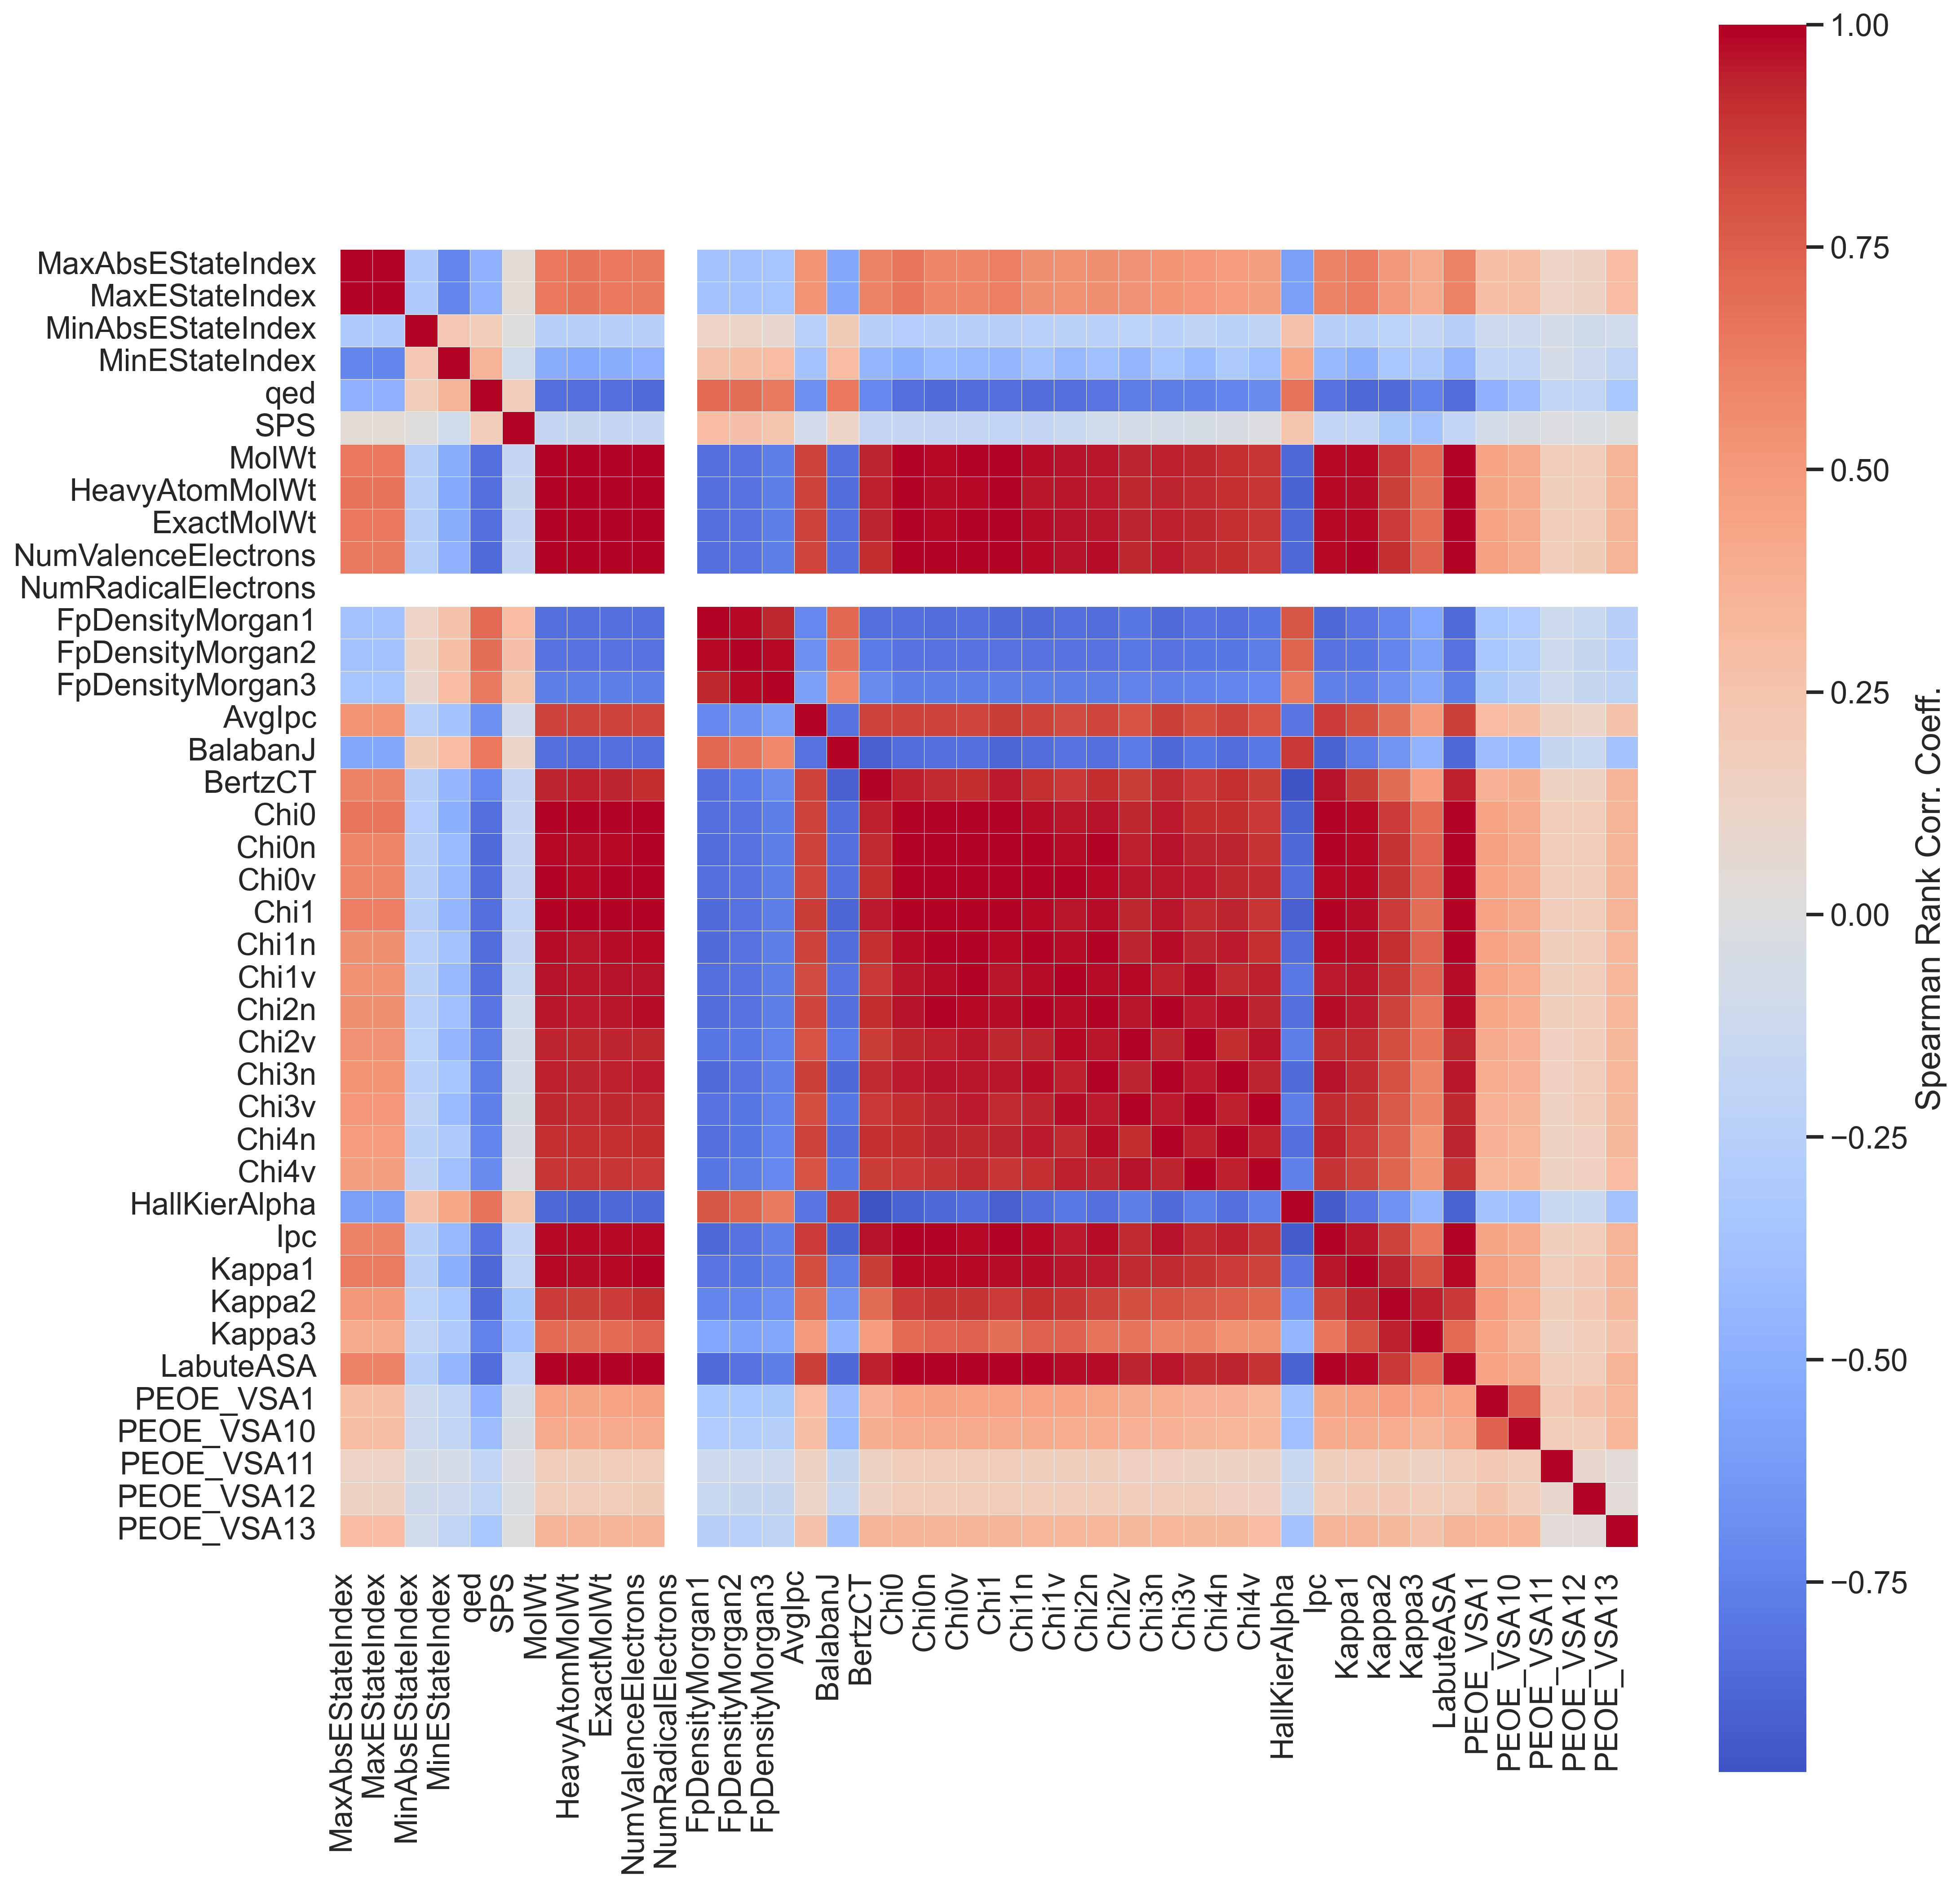

In [19]:
n = 40   # or 50, depending on how large you want the zoom
zoom_corr = corr_features.iloc[:n, :n]
# --- plot the zoomed block ---
sns.set_theme(style="white", context="talk")
plt.figure(figsize=(15, 15))
sns.heatmap(
    zoom_corr,
    cmap="coolwarm",
    center=0,
    square=True,
    cbar_kws={"label": "Spearman Rank Corr. Coeff."},
    xticklabels=True,
    yticklabels=True,
    linewidths=0.2
)
plt.xticks(rotation=90, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

This is the top left corner of the matrix - now it makes sense as to why there are so many correlated features - the electronegativities (Chi0n, Chi0V, ...) are all expected to be heavily correlated to each other. These features should be removed during the process of feature selection. However, it's not only the electronegativities - for instance, BertzCT is heavily correlated with all the electronegativities.

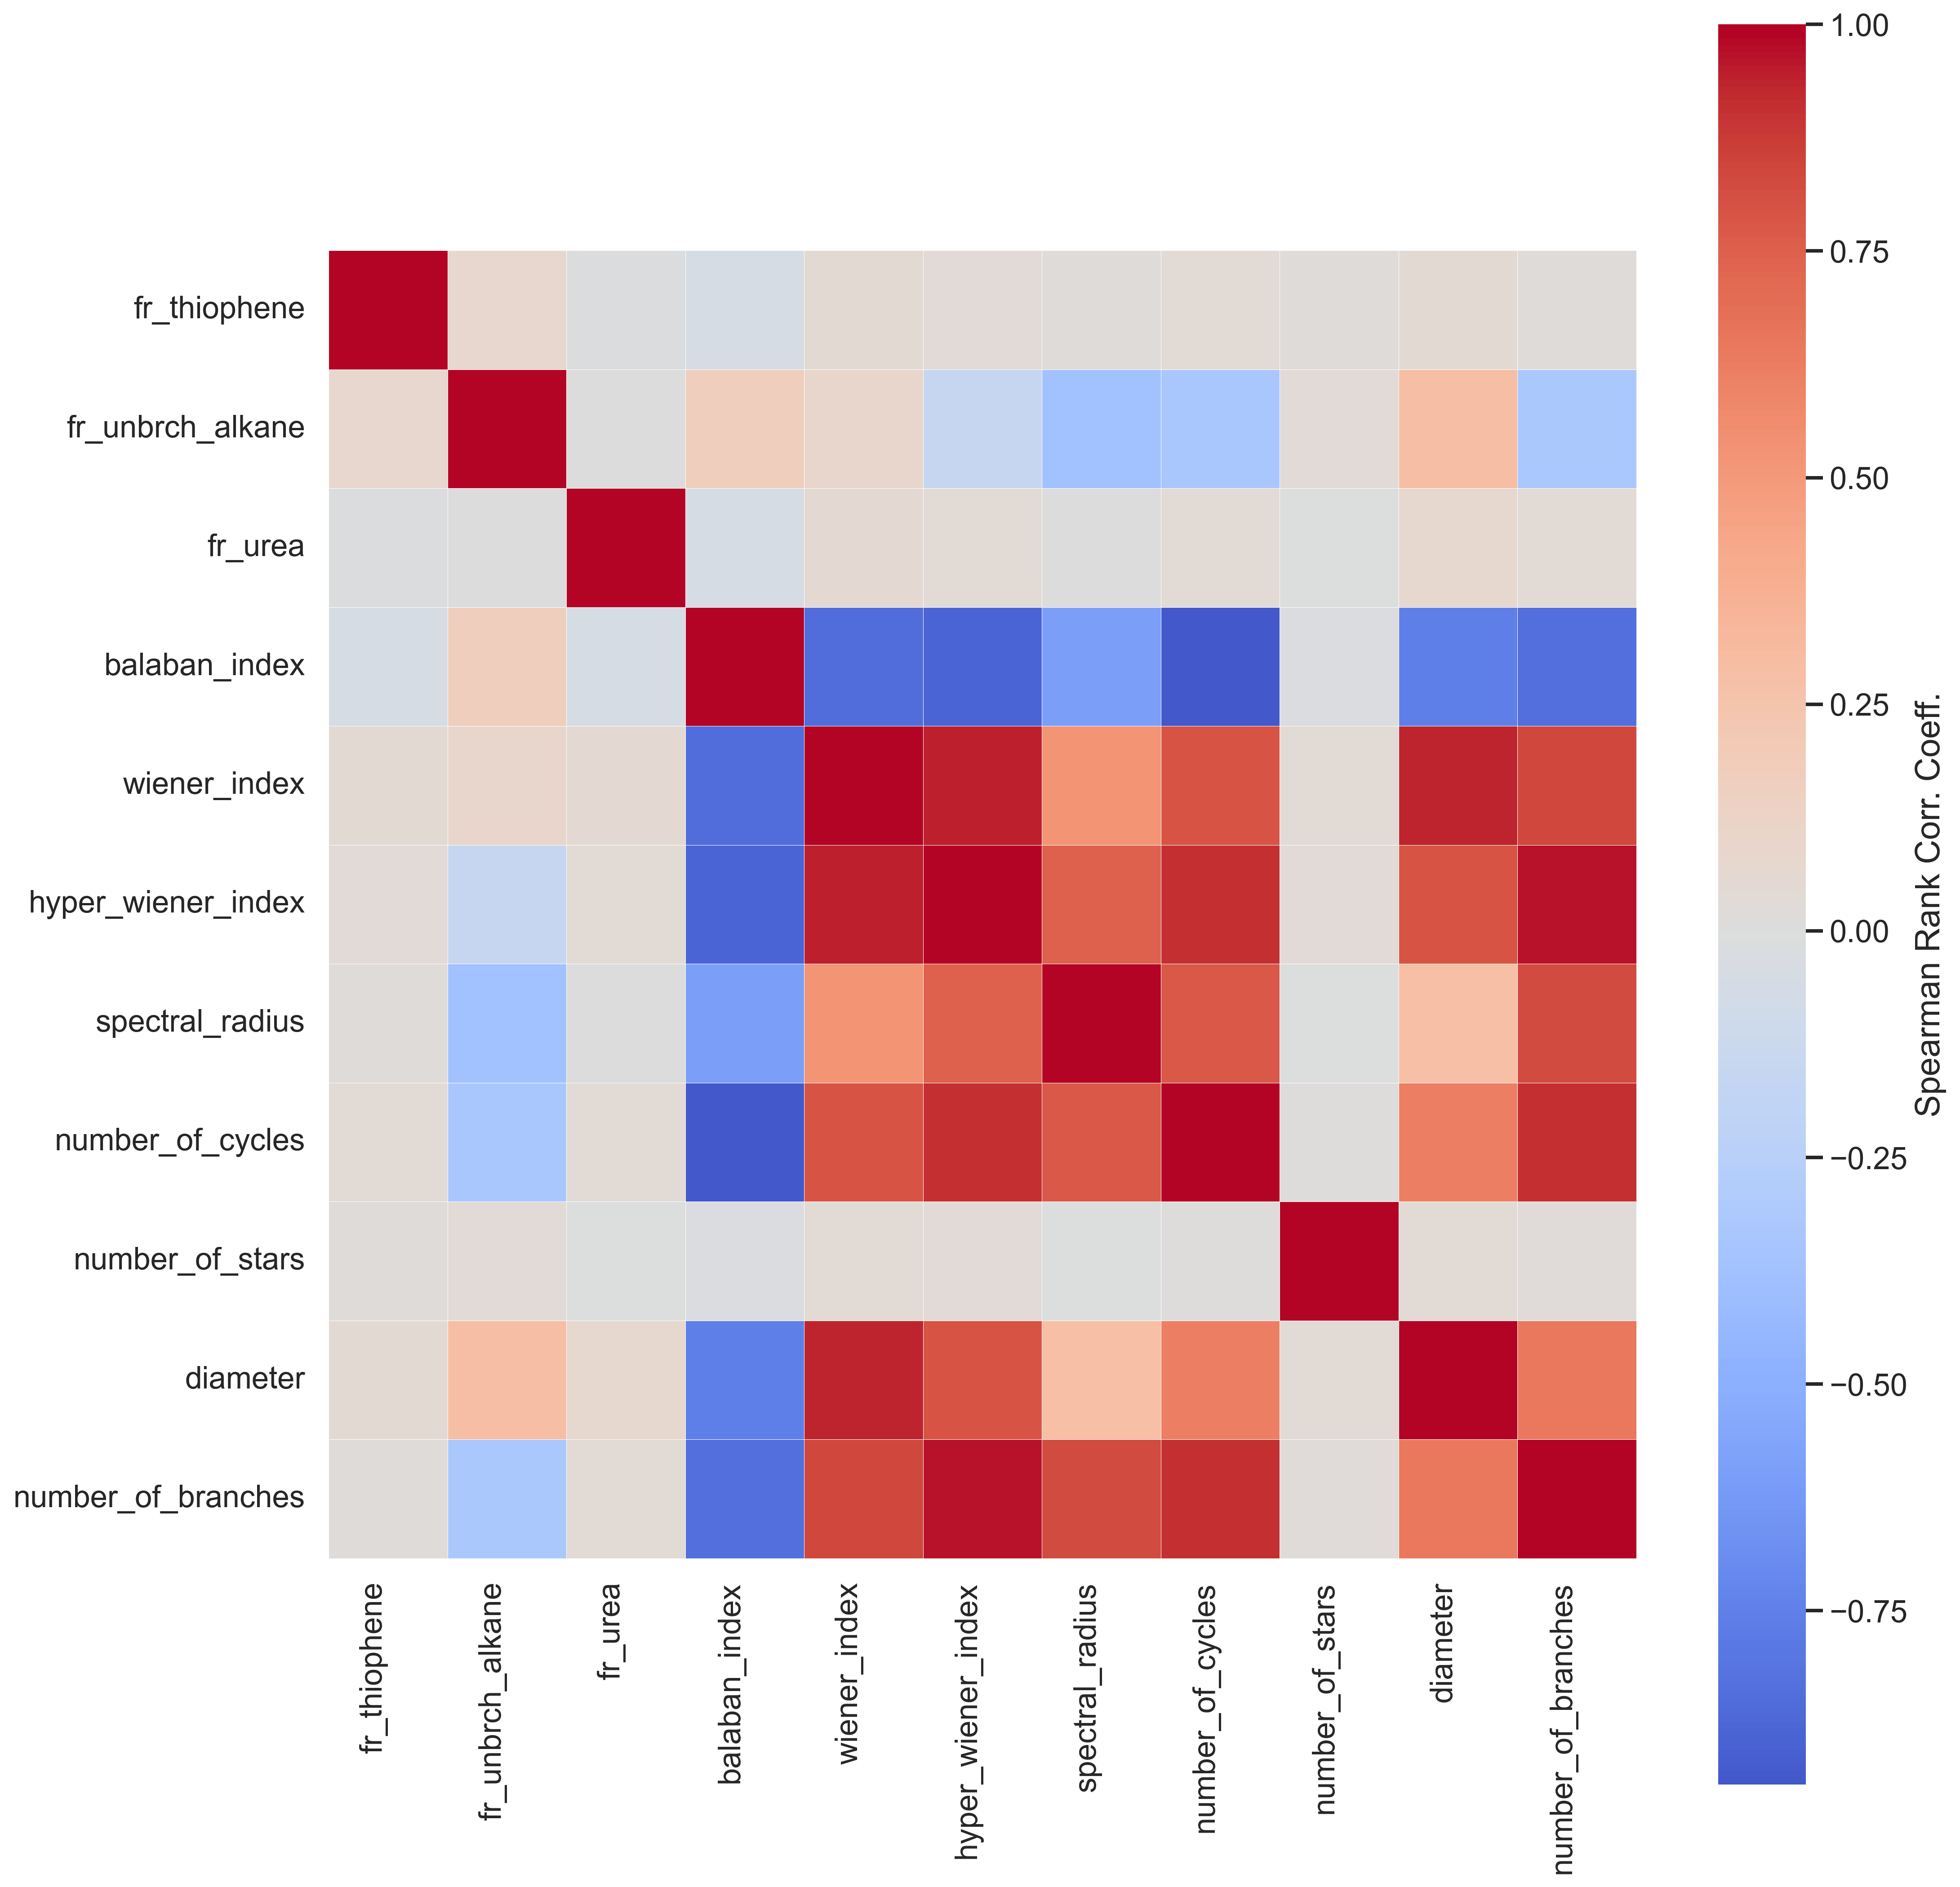

In [20]:
n = 40   # or 50, depending on how large you want the zoom
zoom_corr = corr_features.iloc[len(all_descriptor_names) - 11:len(all_descriptor_names), len(all_descriptor_names) - 11:len(all_descriptor_names)]
# --- plot the zoomed block ---
sns.set_theme(style="white", context="talk")
plt.figure(figsize=(15, 15))
sns.heatmap(
    zoom_corr,
    cmap="coolwarm",
    center=0,
    square=True,
    cbar_kws={"label": "Spearman Rank Corr. Coeff."},
    xticklabels=True,
    yticklabels=True,
    linewidths=0.2
)
plt.xticks(rotation=90, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

If you look at the bottom corner of the matrix, you should see this, and you will get a lot of the topological descriptors being heavily correlated with each other. These should be removed during feature selection (hopefully).

#### <b>PCA scatter plots</b>

In [21]:
pca = PCA(n_components = 2)
X_scaled = StandardScaler().fit_transform(df_descriptors[all_descriptor_names].to_numpy())
X_pca = pca.fit_transform(X_scaled)

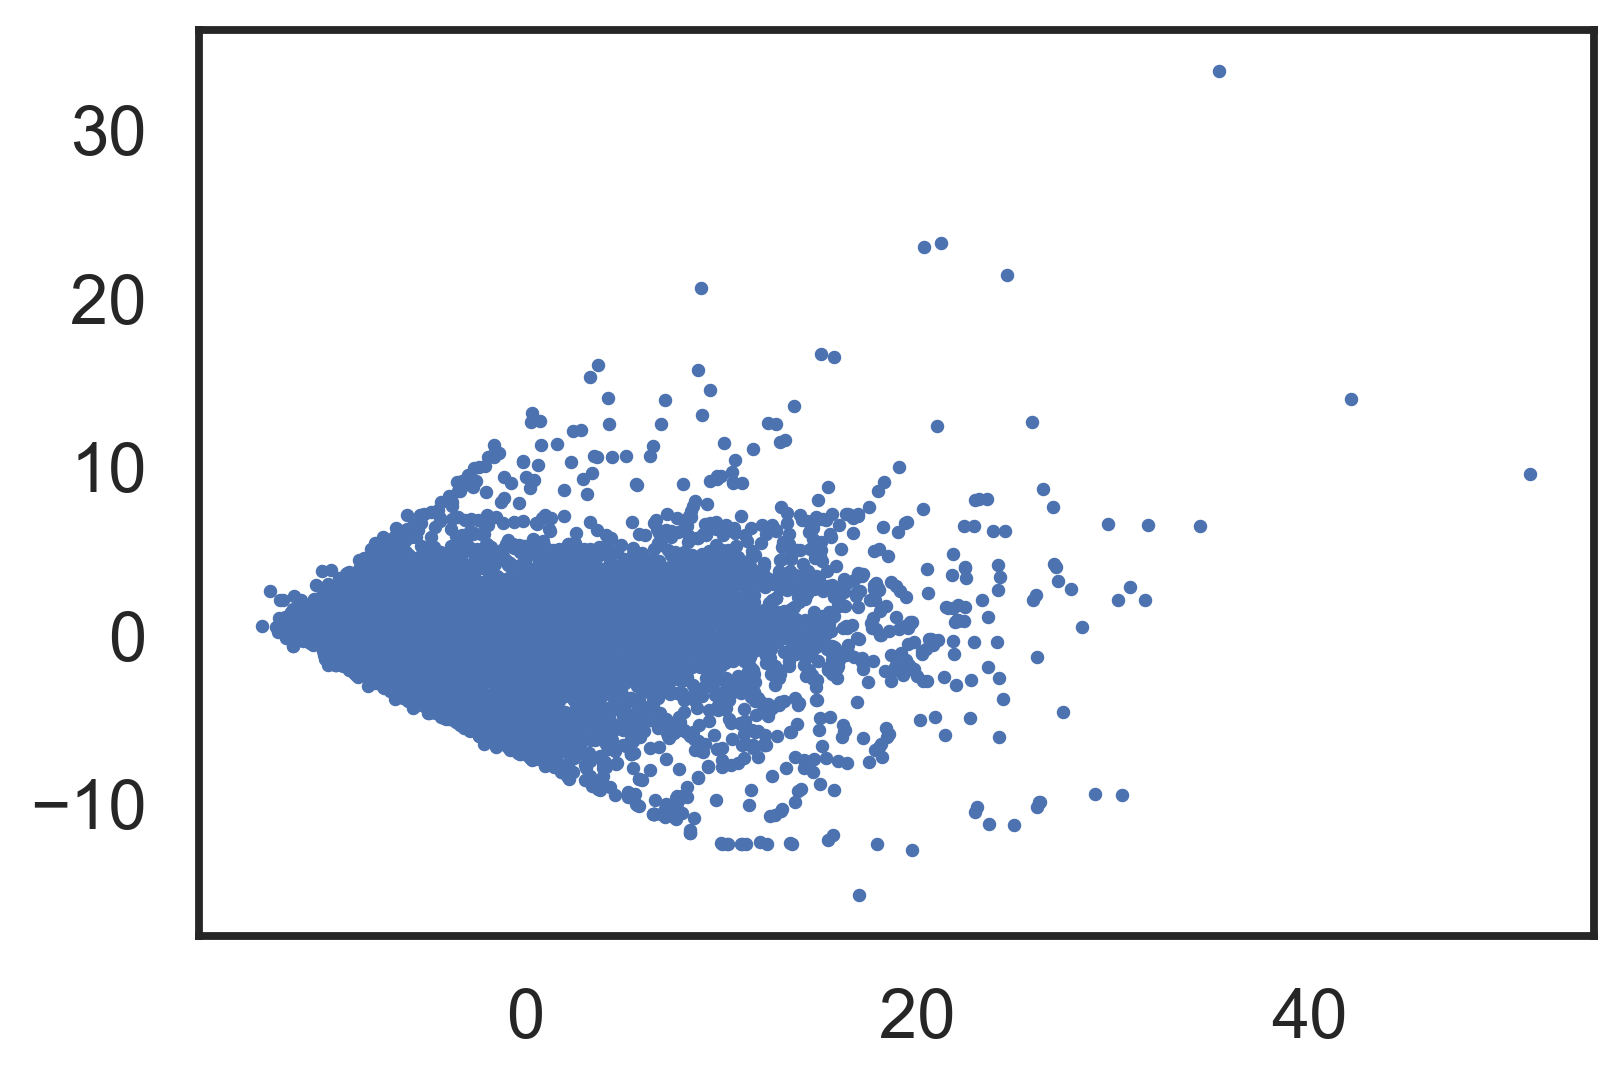

In [22]:
plt.scatter(X_pca[:, 0], X_pca[:, 1], s = 3)

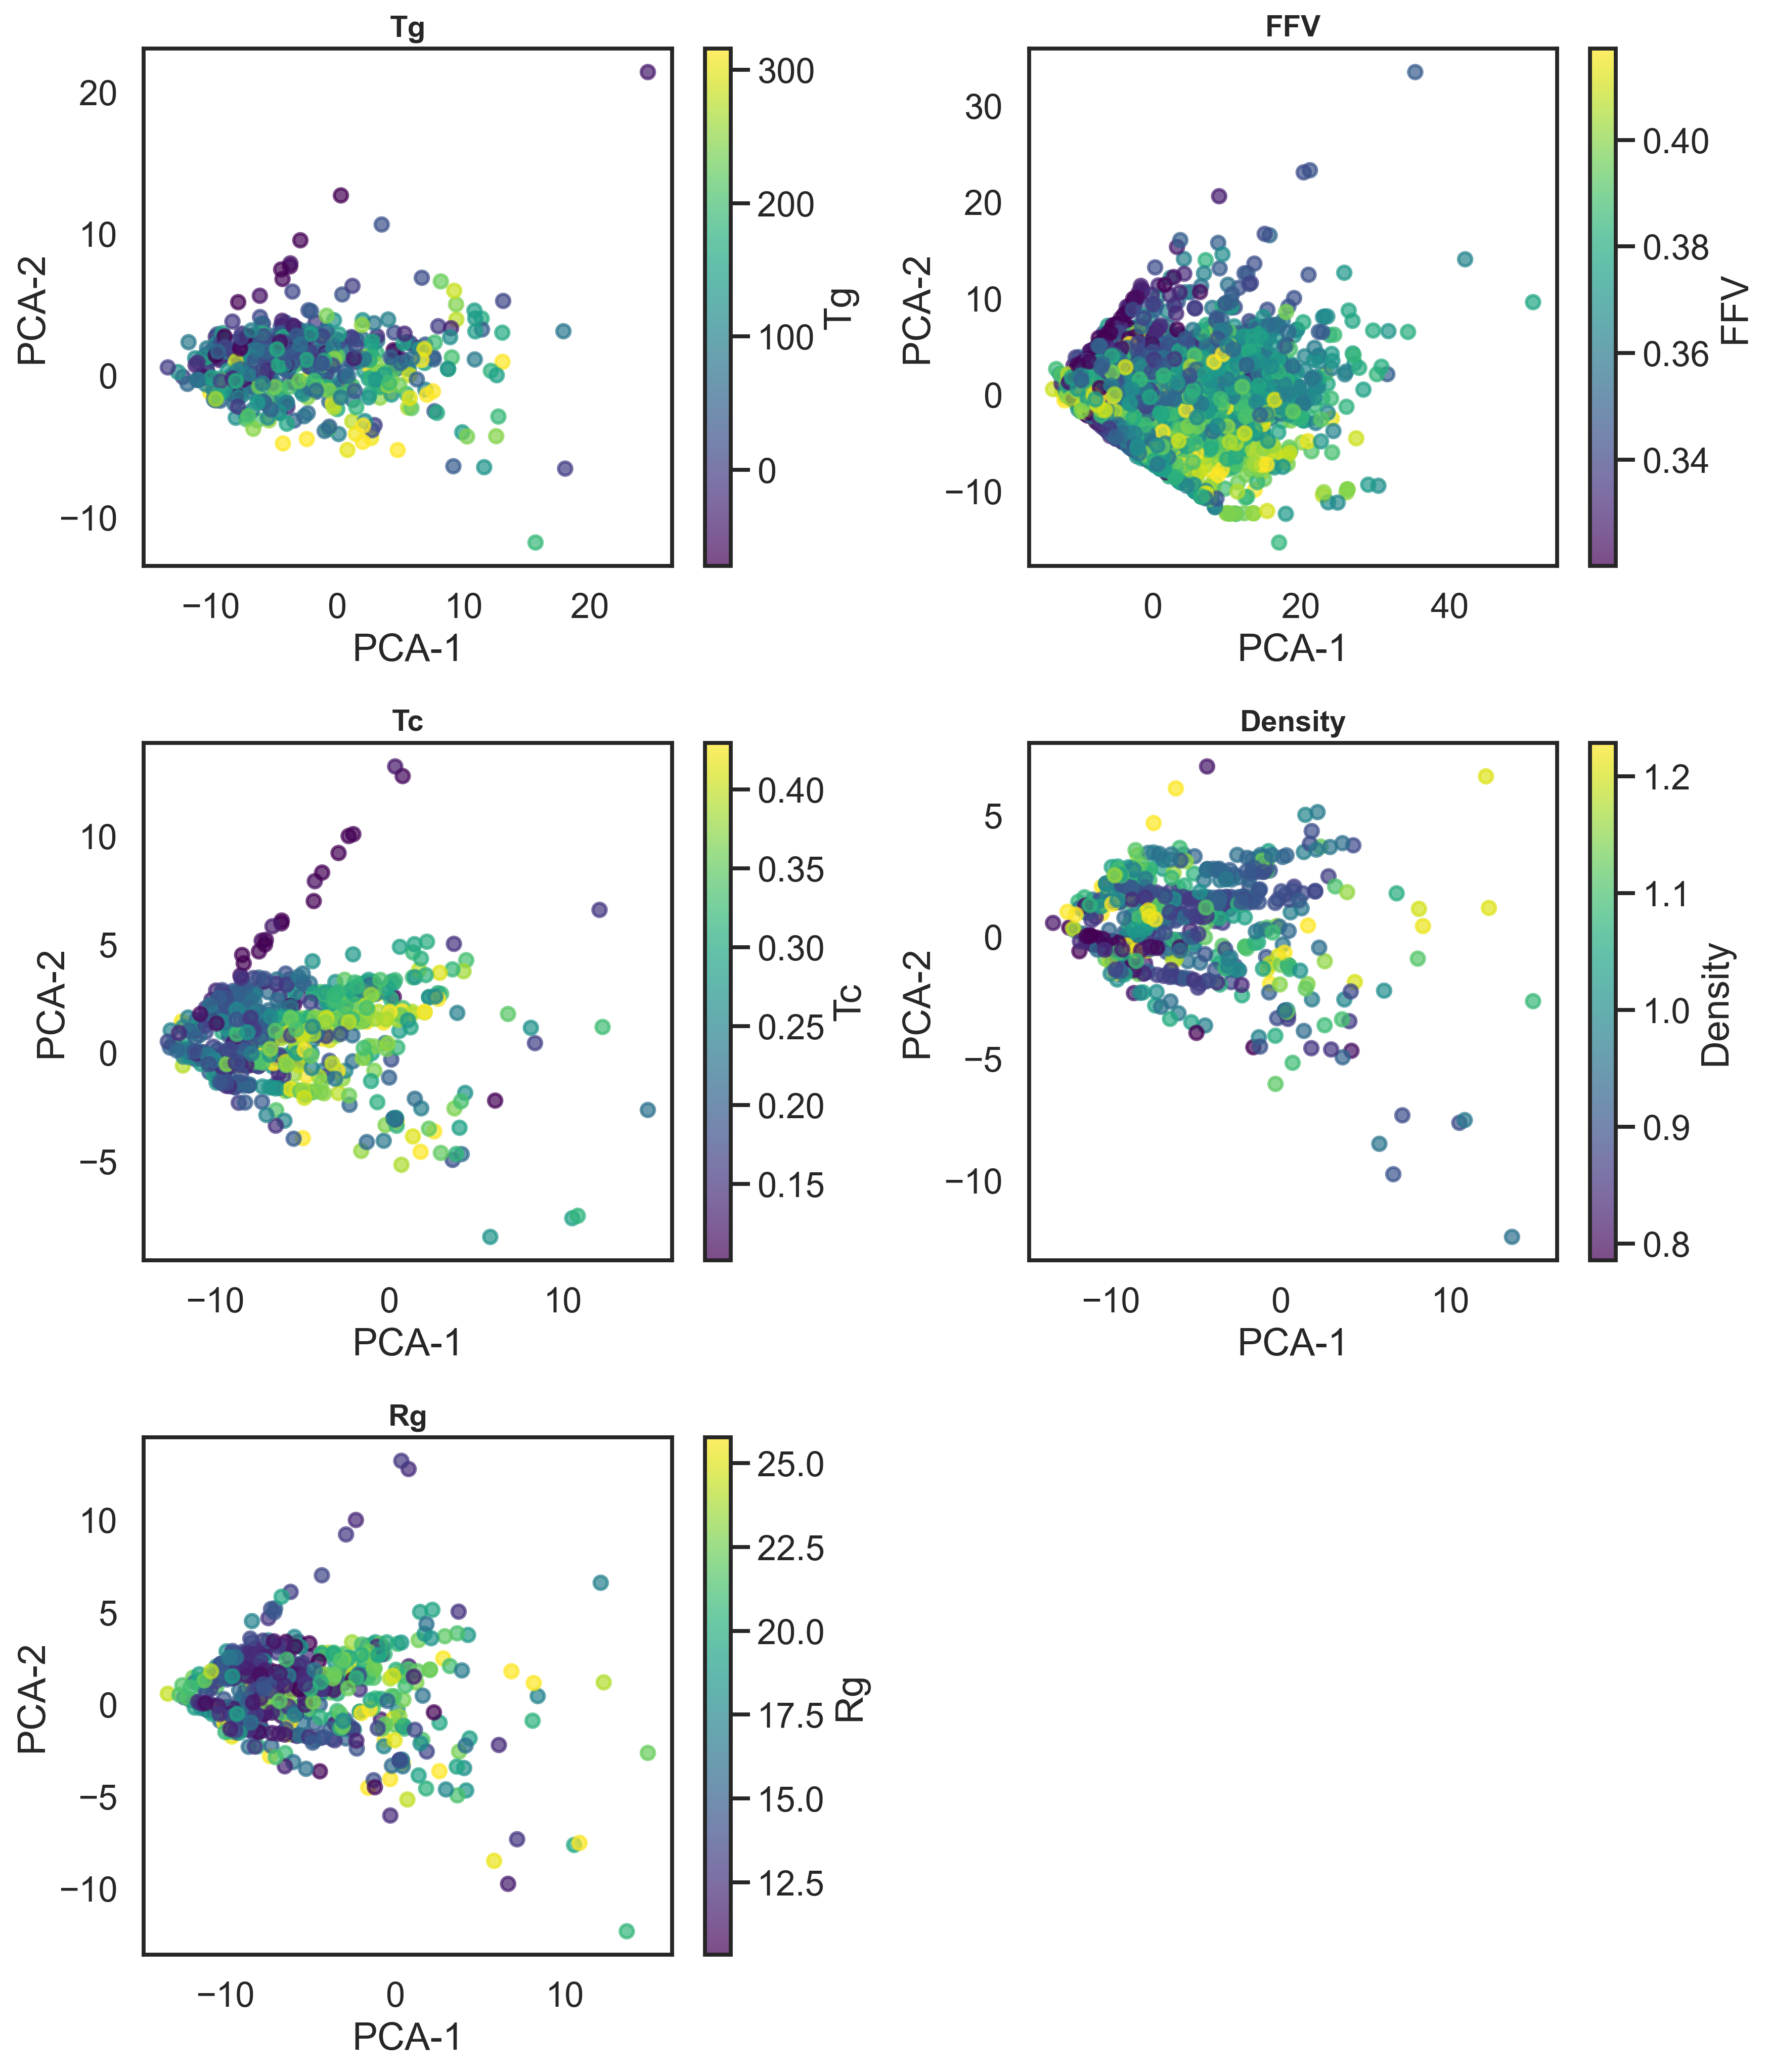

In [ ]:
# i think we need to fit over entire DB and then apply it one property by one, because.. the datapoints are the same, who cares
pca = PCA(n_components = 2)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_descriptors[all_descriptor_names].to_numpy())
X_pca = pca.fit_transform(X_scaled)

fig, axes = plt.subplots(3, 2, figsize=(12, 14))
axes = axes.flatten()

for i, prop in enumerate(properties):
    temp_df = property_to_features_and_label[prop]
    X, y = temp_df[all_descriptor_names].to_numpy(), temp_df[prop].to_numpy()
    X_scaled = scaler.transform(X)
    X_pca = pca.transform(X_scaled)

    vmin, vmax = np.nanpercentile(y, 2), np.nanpercentile(y, 98)

    sc = axes[i].scatter(
        X_pca[:, 0], X_pca[:, 1],
        c=y, cmap='viridis', s=40, alpha=0.7, vmin=vmin, vmax=vmax
    )

    axes[i].set_title(prop, fontsize=14, weight='bold')
    axes[i].set_xlabel("PCA-1")
    axes[i].set_ylabel("PCA-2")

    cbar = fig.colorbar(sc, ax=axes[i])
    cbar.set_label(prop)

for j in range(len(properties), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

Some general comments:
- Chemical space is quite diverse (otherwise, the x-axis and y-axis ranges would have been quite small). Can it be better? Sure. But I think it's diverse enough.
- FFV has so many data points and it is clear to see that the very low FFVs all cluster along some line - which is an indication that we can capture these, if we split our data properly. But mid-high FFVs worry me a little, because they mix together in the embedding space (so maybe it will be a little confusing for the model to capture). However, there are so many datapoints for FFV, that it shouldn't be a problem in my opinion.
- Tg is.. problematic with our current representation. You can see that if you go from top to bottom of the scatter plot, it goes from low Tg to high Tg. This is good, but if you look at the axis ranges, the embedding space is actually quite compressed for the very few data points we have for Tg - which means we don't have enough diverse examples. Also, a lot of low Tgs mix in with the high Tgs.
- Tc is well captured to me. The low Tcs are along a line in the PCA plot, and a lot of the high Tcs are clustered together on the right-hand side.
- Density is... ok. While the very low densities are properly clustered together, you can see that there is mixing between mid-high density points, which is a cause for concern. Perhaps feature selection will help here.
- Rg has the same concerns as Tg - but to a less degree.